In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# **Functions**

**Function to create multiple folds for training**

In [ ]:
def create_folds(df, smote, undersampling, test_size=0.1, num_folds=5, smote_ratio=0.1, undersampling_ratio=0.5):
    """
        Apply train-test split. Then apply k-fold on train data
        Each fold has 100% of total class-1 instance

        Params
        -------
        df: DataFrame with feature and target columns
            unnecessary columns like week, user must be removed already
        smote: bool
            if True, apply smote after train_test split
        test_size: test size for train-test split
        num_folds: Number of folds for K-fold

        Returns
        -------
        final_folds: list
            List of all folds. Each element of this list is another list containing 4 dataframes
            format: [
            [fold_1_Xtrain, fold_1_ytrain, fold_1_Xval, fold_1_yval],
            [fold_2_Xtrain, fold_2_ytrain, fold_2_Xval, fold_2_yval],
            []......
                    ]
    """
    final_folds = []

    features = df.drop(columns=['insider'])
    target = df['insider']
    target.loc[~target.isin([0,1])] = 1

    # Step 1: Stratified Train-Test Split (10% test set)
    X, X_test, y, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42, stratify=target
    )
    X.reset_index(inplace=True, drop=True)
    y=y.reset_index()
    y=y['insider']

    # Step 2: K-Fold Cross-Validation on Train Set (Keeping All Class 1 + SMOTE)
    num_folds = num_folds
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # # Identify all class 1 samples in training set
    # class_1_indices = np.where(y != 0)[0]

    for train_index, val_index in skf.split(X, y):
        # # Ensure all class 1 samples are included in the training set
        # train_index = np.concatenate([train_index, class_1_indices])
        # train_index = np.unique(train_index)  # Remove duplicates

        X_train_fold, X_val_fold = X.loc[train_index], X.loc[val_index]
        y_train_fold, y_val_fold = y.loc[train_index], y.loc[val_index]

        if smote:
            # Apply SMOTE on the training fold
            smote = SMOTE(sampling_strategy=smote_ratio, random_state=42)  # Adjust as needed
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        else:
            X_train_resampled = X_train_fold
            y_train_resampled = y_train_fold

        if undersampling:
            # undersampling
            undersampler = RandomUnderSampler(sampling_strategy=undersampling_ratio, random_state=42)  # Adjust ratio
            X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

        final_folds.append([X_train_resampled, y_train_resampled, X_val_fold, y_val_fold])

    return final_folds, [X_test, y_test]

**Model Implementation Function**

In [ ]:
def evaluate_folds(folds, model=None):
    """
    Trains a model on each fold and prints/plots evaluation metrics.
    Returns average scores across all folds, the final trained model,
    and per-fold scores for formatting.

    Parameters
    ----------
    folds : list
        List of [X_train, y_train, X_val, y_val] from create_folds().
    model : sklearn model, optional
        Defaults to RandomForestClassifier.

    Returns
    -------
    avg_scores : dict
        Dictionary of average metrics across all folds.
    final_model : trained model
        Model trained on all training folds combined.
    fold_scores : dict
        Dictionary of per-fold metrics suitable for formatting.
    """
    if model is None:
        model = RandomForestClassifier(random_state=42)

    all_precisions = []
    all_recalls = []
    all_f1s = []
    all_avg_precisions = []
    fold_scores = {}

    print("=== Cross-Validation Fold Results ===")
    for i, (X_train, y_train, X_val, y_val) in enumerate(folds):
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        y_proba = clf.predict_proba(X_val)[:, 1]

        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        f1 = f1_score(y_val, y_pred, zero_division=0)
        avg_precision = average_precision_score(y_val, y_proba)
        cm = confusion_matrix(y_val, y_pred)
        report = classification_report(y_val, y_pred, zero_division=0)

        print(f"\n\nFold {i+1}")
        print(".....VALIDATION EVALUATION.....")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print("Classification Report:\n", report)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=clf.classes_)
        disp.plot()
        plt.title(f"Fold {i+1} - Validation CM")
        plt.show()

        # Store per-fold scores
        fold_scores[f"Fold {i+1}"] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'average_precision': avg_precision
        }

        # For computing average
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
        all_avg_precisions.append(avg_precision)

    avg_scores = {
        'avg_precision': np.mean(all_precisions),
        'avg_recall': np.mean(all_recalls),
        'avg_f1_score': np.mean(all_f1s),
        'avg_average_precision': np.mean(all_avg_precisions)
    }

    print("\n=== AVERAGE CROSS-VALIDATION SCORES ===")
    for metric, score in avg_scores.items():
        print(f"{metric}: {score:.4f}")

    # Train final model on all folds' train + val combined
    print("\nTraining final model on all data...")
    X_full = np.concatenate([fold[0] for fold in folds] + [fold[2] for fold in folds])
    y_full = np.concatenate([fold[1] for fold in folds] + [fold[3] for fold in folds])
    final_model = model
    final_model.fit(X_full, y_full)

    return avg_scores, final_model, fold_scores


**Function for Testing Models**

In [ ]:
def evaluate_on_test(model, test):
    """
    Evaluates a trained model on the test set and plots confusion matrix.

    Parameters
    ----------
    model : sklearn model
        Trained model.
    test : tuple
        (X_test, y_test)

    Returns
    -------
    test_scores : dict
        Dictionary of evaluation metrics on the test set.
    """
    X_test, y_test = test
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    avg_precision = average_precision_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print("\n\n=== FINAL TEST EVALUATION ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("Classification Report:\n", report)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    plt.title("Test Set Confusion Matrix")
    plt.show()

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average_precision': avg_precision,
        'classification_report': report,
        'confusion_matrix': cm
    }

**Function for testing and evaluating Meta learner model**

In [ ]:
def train_stacking_ensemble_with_meta_learner(folds, test):
    oof_meta_features = []
    oof_meta_targets = []

    print("\n=== Generating Out-of-Fold (OOF) Meta-Features ===")

    for i, (X_train, y_train, X_val, y_val) in enumerate(folds):
        print(f"\nProcessing Fold {i+1}...")

        rf = RandomForestClassifier(random_state=42)
        dt = DecisionTreeClassifier(random_state=42)
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        cat = CatBoostClassifier(verbose=0, random_state=42)

        rf.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        xgb.fit(X_train, y_train)
        cat.fit(X_train, y_train)

        rf_val = rf.predict_proba(X_val)[:, 1]
        dt_val = dt.predict_proba(X_val)[:, 1]
        xgb_val = xgb.predict_proba(X_val)[:, 1]
        cat_val = cat.predict_proba(X_val)[:, 1]

        meta_features_fold = pd.DataFrame({
            'rf': rf_val,
            'dt': dt_val,
            'xgb': xgb_val,
            'cat': cat_val
        })
        oof_meta_features.append(meta_features_fold)
        oof_meta_targets.append(y_val.reset_index(drop=True))

    meta_X_train = pd.concat(oof_meta_features, ignore_index=True)
    meta_y_train = pd.concat(oof_meta_targets, ignore_index=True)

    # Scale meta-features
    scaler_meta = StandardScaler()
    meta_X_train_scaled = scaler_meta.fit_transform(meta_X_train)

    meta_learner = LogisticRegression(max_iter=1000)
    meta_learner.fit(meta_X_train_scaled, meta_y_train)

    # === Evaluation on OOF meta-training data ===
    meta_train_preds = meta_learner.predict(meta_X_train_scaled)
    meta_train_proba = meta_learner.predict_proba(meta_X_train_scaled)[:, 1]

    precision_oof = precision_score(meta_y_train, meta_train_preds, zero_division=0)
    recall_oof = recall_score(meta_y_train, meta_train_preds, zero_division=0)
    f1_oof = f1_score(meta_y_train, meta_train_preds, zero_division=0)
    avg_precision_oof = average_precision_score(meta_y_train, meta_train_proba)
    report_oof = classification_report(meta_y_train, meta_train_preds, zero_division=0)
    cm_oof = confusion_matrix(meta_y_train, meta_train_preds)

    print("\n=== Meta-Learner Evaluation on OOF Training Data ===")
    print(f"Precision: {precision_oof:.4f}")
    print(f"Recall: {recall_oof:.4f}")
    print(f"F1 Score: {f1_oof:.4f}")
    print(f"Average Precision: {avg_precision_oof:.4f}")
    print("Classification Report:\n", report_oof)

    disp_oof = ConfusionMatrixDisplay(confusion_matrix=cm_oof)
    disp_oof.plot()
    plt.title("Meta-Learner OOF Training Confusion Matrix")
    plt.show()

    # === Test Evaluation ===
    X_test, y_test = test
    full_X = pd.concat([fold[0] for fold in folds], ignore_index=True)
    full_y = pd.concat([fold[1] for fold in folds], ignore_index=True)

    rf.fit(full_X, full_y)
    dt.fit(full_X, full_y)
    xgb.fit(full_X, full_y)
    cat.fit(full_X, full_y)

    X_test_df = pd.DataFrame(X_test, columns=full_X.columns)

    rf_test = rf.predict_proba(X_test)[:, 1]
    dt_test = dt.predict_proba(X_test)[:, 1]
    xgb_test = xgb.predict_proba(X_test)[:, 1]
    cat_test = cat.predict_proba(X_test)[:, 1]

    meta_X_test = pd.DataFrame({
        'rf': rf_test,
        'dt': dt_test,
        'xgb': xgb_test,
        'cat': cat_test
    })

    meta_X_test_scaled = scaler_meta.transform(meta_X_test)

    meta_preds = meta_learner.predict(meta_X_test_scaled)
    meta_proba = meta_learner.predict_proba(meta_X_test_scaled)[:, 1]

    precision = precision_score(y_test, meta_preds, zero_division=0)
    recall = recall_score(y_test, meta_preds, zero_division=0)
    f1 = f1_score(y_test, meta_preds, zero_division=0)
    avg_precision = average_precision_score(y_test, meta_proba)
    report = classification_report(y_test, meta_preds, zero_division=0)
    cm = confusion_matrix(y_test, meta_preds)

    print("\n=== Meta-Learner Evaluation on Test Set ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("Classification Report:\n", report)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Stacking Ensemble Test Confusion Matrix")
    plt.show()

    return {
        # Test set
        'predictions': meta_preds,
        'probabilities': meta_proba,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average_precision': avg_precision,
        'classification_report': report,
        'confusion_matrix': cm,
        # OOF meta-training set
        'oof_precision': precision_oof,
        'oof_recall': recall_oof,
        'oof_f1_score': f1_oof,
        'oof_average_precision': avg_precision_oof,
        'oof_classification_report': report_oof,
        'oof_confusion_matrix': cm_oof,
        # Trained components
        'scaler_meta': scaler_meta,
        'meta_learner': meta_learner
    }

**Score Formating Function**

In [ ]:
import pandas as pd

def format_scores(scores_dict):
    """
    Formats per-fold evaluation metrics into a pandas DataFrame,
    including an additional row for average metrics.

    Parameters
    ----------
    scores_dict : dict
        Dictionary where keys are fold names (e.g., 'Fold 1') and values are
        dicts with keys: 'precision', 'recall', 'f1_score', 'average_precision'.

    Returns
    -------
    pd.DataFrame
        DataFrame containing metrics for each fold and an 'Average' row.
    """
    rows = []

    for fold_name, metrics in scores_dict.items():
        rows.append({
            'Fold': fold_name,
            'Precision': round(metrics['precision'], 4),
            'Recall': round(metrics['recall'], 4),
            'F1 Score': round(metrics['f1_score'], 4),
            'Avg Precision': round(metrics['average_precision'], 4)
        })

    df = pd.DataFrame(rows)
    df = df.set_index('Fold')

    # Add average row
    avg_metrics = df.mean()
    df.loc['Average'] = avg_metrics.round(4)

    return df

**Model Comparison Function**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_model_comparison(model_scores_dict, metrics_to_plot=None, title="Model Comparison Across Evaluation Metrics"):
    """
    Plots a bar chart comparing evaluation metrics across multiple models.

    Parameters
    ----------
    model_scores_dict : dict
        Dictionary where keys are model names (str), and values are dictionaries of average metrics.
        Example:
        {
            'Random Forest': {'precision': 0.85, 'recall': 0.82, ...},
            'Logistic Regression': {'precision': 0.81, 'recall': 0.79, ...},
            ...
        }
    metrics_to_plot : list of str, optional
        List of metric keys to plot (e.g., ['precision', 'recall', 'f1_score']).
        If None, defaults to all common metrics.
    title : str, optional
        The title of the graph.
    """
    # Set default metrics if not provided
    if metrics_to_plot is None:
        metrics_to_plot = ['precision', 'recall', 'f1_score', 'average_precision']

    model_names = list(model_scores_dict.keys())
    num_models = len(model_names)
    num_metrics = len(metrics_to_plot)

    # Gather data
    metric_data = {metric: [model_scores_dict[model].get(metric, 0) for model in model_names]
                   for metric in metrics_to_plot}

    # Plot
    x = np.arange(num_models)
    width = 0.25  # Increase width for wider bars (previously 0.2, now 0.25)

    plt.figure(figsize=(12, 6))
    bars = []

    for i, metric in enumerate(metrics_to_plot):
        bar = plt.bar(x + i * width, metric_data[metric], width, label=metric.replace("_", " ").title())
        bars.append(bar)

    # Annotate the bars with percentage values
    for i, bar in enumerate(bars):
        for rect in bar:
            height = rect.get_height()
            # Display the value on top of each bar as percentage
            plt.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height * 100:.2f}%',
                     ha='center', va='bottom', fontsize=8, color='black')  # Smaller font size (8)

    plt.xticks(x + width * (num_metrics - 1) / 2, model_names, rotation=30)
    plt.ylabel("Score")
    plt.title(title)  # Use the provided title
    plt.ylim(0, 1.05)

    # Format the Y-axis to display as percentages
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    # Move the legend to the side (right side of the plot)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

**Feature Selection Function**

In [ ]:
from sklearn.feature_selection import f_classif, mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def rank_and_plot_top_features(X, y, top_k=20, return_df=False):
    """
    Computes ANOVA F-score, Mutual Information, and Combined Rank for features,
    and plots top-k features by each method.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series or array-like
        Target variable.
    top_k : int, default=20
        Number of top features to display in the plot.
    return_df : bool, default=False
        If True, returns top_k feature names and full ranked DataFrame.

    Returns
    -------
    top_features : list
        List of top_k features by Combined Rank.
    ranked_df : pd.DataFrame (optional)
        Full table with ANOVA, MI, and combined rankings.
    """
    # Step 1: Calculate scores
    f_scores, _ = f_classif(X, y)
    mi_scores = mutual_info_classif(X, y, random_state=42)

    ranked_df = pd.DataFrame({
        'Feature': X.columns,
        'ANOVA_F': f_scores,
        'MI': mi_scores
    })

    # Step 2: Calculate ranks
    ranked_df['ANOVA_Rank'] = ranked_df['ANOVA_F'].rank(ascending=False)
    ranked_df['MI_Rank'] = ranked_df['MI'].rank(ascending=False)
    ranked_df['Combined_Rank'] = (ranked_df['ANOVA_Rank'] + ranked_df['MI_Rank']) / 2
    ranked_df = ranked_df.sort_values(by='Combined_Rank').reset_index(drop=True)

    # Step 3: Select top-k
    top_combined = ranked_df.head(top_k)
    top_features = top_combined['Feature'].tolist()

    # Step 4: Prepare data for plots
    top_anova = ranked_df.sort_values('ANOVA_F', ascending=False).head(top_k)
    top_mi = ranked_df.sort_values('MI', ascending=False).head(top_k)

    # Step 5: Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    sns.set(style="whitegrid")

    sns.barplot(ax=axs[0], x='ANOVA_F', y='Feature', data=top_anova, palette="Blues_r")
    axs[0].set_title(f"Top {top_k} Features by ANOVA F-score")

    sns.barplot(ax=axs[1], x='MI', y='Feature', data=top_mi, palette="Greens_r")
    axs[1].set_title(f"Top {top_k} Features by Mutual Information")

    sns.barplot(ax=axs[2], x='Combined_Rank', y='Feature', data=top_combined, palette="Purples_r")
    axs[2].invert_xaxis()  # Lower rank = more important
    axs[2].set_title(f"Top {top_k} Features by Combined Rank")

    plt.tight_layout()
    plt.show()

    if return_df:
        return top_features, ranked_df
    return top_features

# **MODEL IMPLEMENTATION**

# **Scenario 1: All Features ( Baseline )**

In [ ]:
session_path = 'session.csv'
df_s1 = pd.read_csv(session_path)
df_s1 = df_s1.drop(columns=['Unnamed: 0','starttime','endtime','sessionid','week'])
folds_s1, test_s1 = create_folds(df_s1, smote=False, undersampling=False, smote_ratio=0.03, undersampling_ratio=0.04)
X_train_s1, y_train_s1, X_val_s1, y_val_s1 = folds_s1[0]
X_test_s1, y_test_s1 = test_s1

<ipython-input-3-9c3d3292ea1f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[~target.isin([0,1])] = 1


# **Training on Scenario 1: All Features ( Baseline )**

**Random Forest training on Scenario 1**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9917
Recall: 0.5980
F1 Score: 0.7461
Average Precision: 0.9390
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.60      0.75       199

    accuracy                           1.00     78074
   macro avg       1.00      0.80      0.87     78074
weighted avg       1.00      1.00      1.00     78074



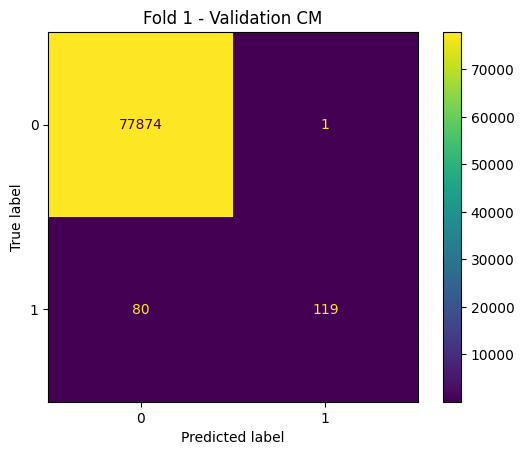



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9667
Recall: 0.5829
F1 Score: 0.7273
Average Precision: 0.9203
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.97      0.58      0.73       199

    accuracy                           1.00     78074
   macro avg       0.98      0.79      0.86     78074
weighted avg       1.00      1.00      1.00     78074



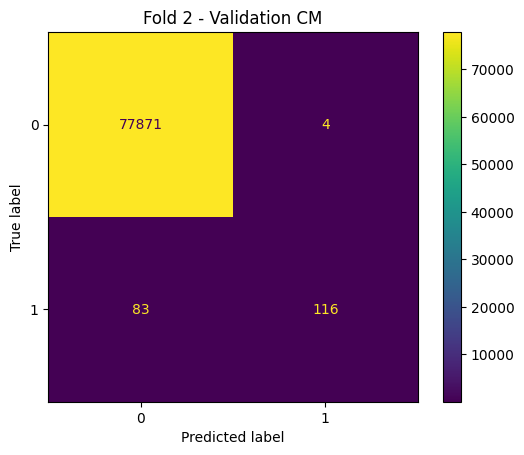



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9817
Recall: 0.5404
F1 Score: 0.6971
Average Precision: 0.9274
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.54      0.70       198

    accuracy                           1.00     78073
   macro avg       0.99      0.77      0.85     78073
weighted avg       1.00      1.00      1.00     78073



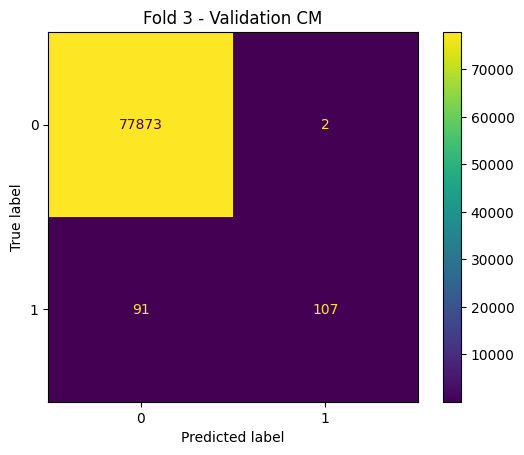



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9917
Recall: 0.6061
F1 Score: 0.7524
Average Precision: 0.9516
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.61      0.75       198

    accuracy                           1.00     78073
   macro avg       1.00      0.80      0.88     78073
weighted avg       1.00      1.00      1.00     78073



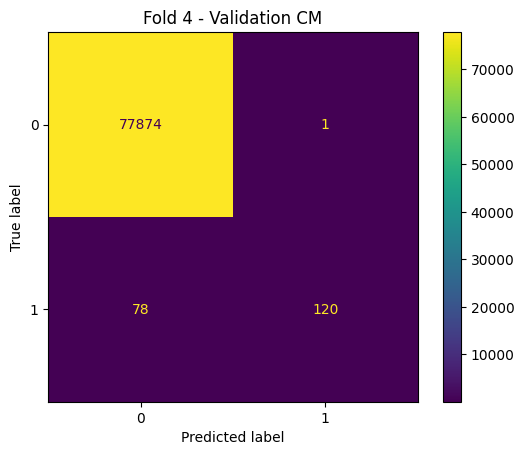



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9907
Recall: 0.5327
F1 Score: 0.6928
Average Precision: 0.9288
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.99      0.53      0.69       199

    accuracy                           1.00     78073
   macro avg       0.99      0.77      0.85     78073
weighted avg       1.00      1.00      1.00     78073



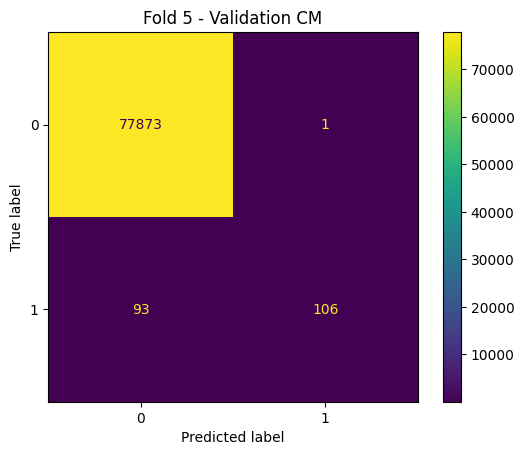


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9845
avg_recall: 0.5720
avg_f1_score: 0.7231
avg_average_precision: 0.9334

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9917  0.5980    0.7461         0.9390
Fold 2      0.9667  0.5829    0.7273         0.9203
Fold 3      0.9817  0.5404    0.6971         0.9274
Fold 4      0.9917  0.6061    0.7524         0.9516
Fold 5      0.9907  0.5327    0.6928         0.9288
Average     0.9845  0.5720    0.7231         0.9334


In [ ]:
# Train Random Forest model on the folds and evaluate
rf_model = RandomForestClassifier(random_state=42)
avg_rf_scores_s1, rf_model_s1, rf_scores_s1 = evaluate_folds(folds_s1, model=rf_model)
clean_df = format_scores(rf_scores_s1)
print("\n===== Evaluation Summary =====")
print(clean_df)

**XGBoost training on Scenario 1**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9727
Recall: 0.8945
F1 Score: 0.9319
Average Precision: 0.9825
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.97      0.89      0.93       199

    accuracy                           1.00     78074
   macro avg       0.99      0.95      0.97     78074
weighted avg       1.00      1.00      1.00     78074



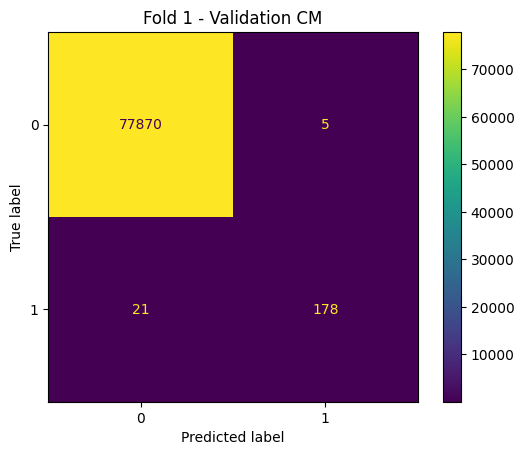



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9385
Recall: 0.9196
F1 Score: 0.9289
Average Precision: 0.9647
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.94      0.92      0.93       199

    accuracy                           1.00     78074
   macro avg       0.97      0.96      0.96     78074
weighted avg       1.00      1.00      1.00     78074



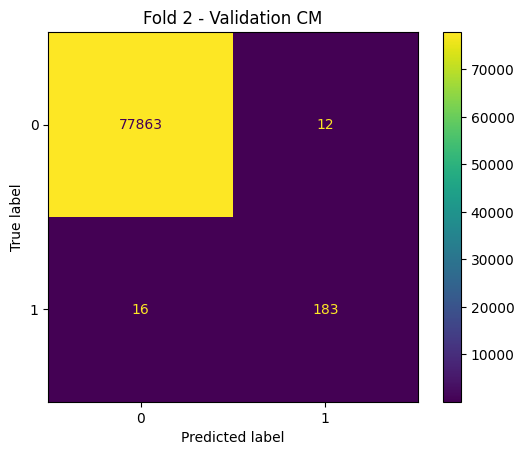



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9424
Recall: 0.9091
F1 Score: 0.9254
Average Precision: 0.9808
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.94      0.91      0.93       198

    accuracy                           1.00     78073
   macro avg       0.97      0.95      0.96     78073
weighted avg       1.00      1.00      1.00     78073



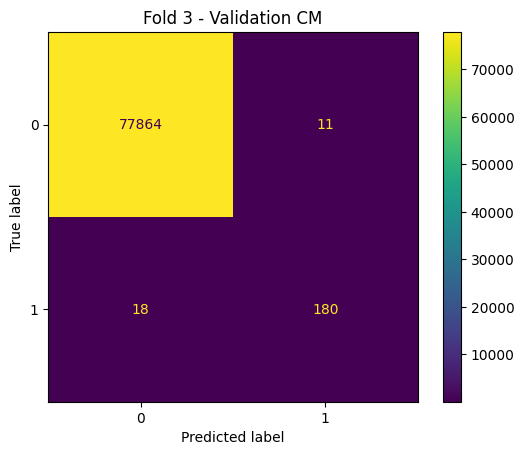



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9412
Recall: 0.8889
F1 Score: 0.9143
Average Precision: 0.9790
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.94      0.89      0.91       198

    accuracy                           1.00     78073
   macro avg       0.97      0.94      0.96     78073
weighted avg       1.00      1.00      1.00     78073



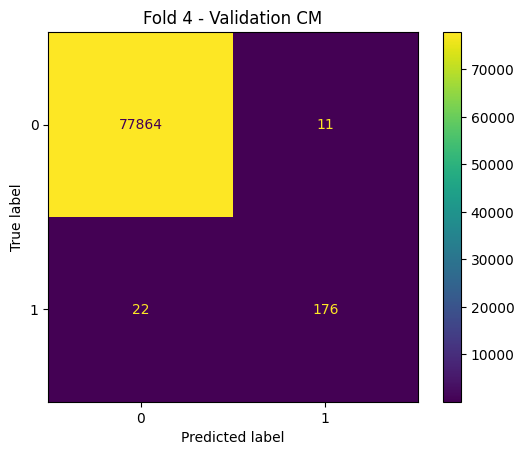



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9448
Recall: 0.8593
F1 Score: 0.9000
Average Precision: 0.9762
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.94      0.86      0.90       199

    accuracy                           1.00     78073
   macro avg       0.97      0.93      0.95     78073
weighted avg       1.00      1.00      1.00     78073



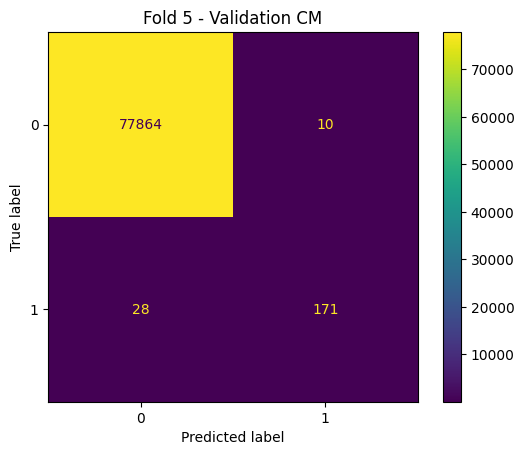


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9479
avg_recall: 0.8943
avg_f1_score: 0.9201
avg_average_precision: 0.9766

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9727  0.8945    0.9319         0.9825
Fold 2      0.9385  0.9196    0.9289         0.9647
Fold 3      0.9424  0.9091    0.9254         0.9808
Fold 4      0.9412  0.8889    0.9143         0.9790
Fold 5      0.9448  0.8593    0.9000         0.9762
Average     0.9479  0.8943    0.9201         0.9766


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
avg_xgb_scores_s1, xgb_model_s1, xgb_scores_s1 = evaluate_folds(folds_s1, model=xgb_model)
clean_df = format_scores(xgb_scores_s1)
print("\n===== Evaluation Summary =====")
print(clean_df)

**Decision Tree training on Scenario 1**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.8817
Recall: 0.8241
F1 Score: 0.8519
Average Precision: 0.7271
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.88      0.82      0.85       199

    accuracy                           1.00     78074
   macro avg       0.94      0.91      0.93     78074
weighted avg       1.00      1.00      1.00     78074



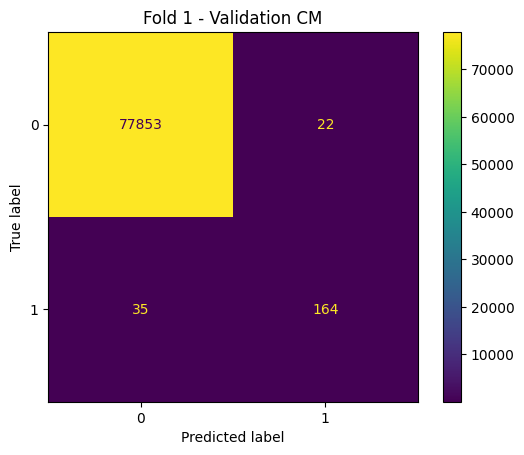



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.8299
Recall: 0.8090
F1 Score: 0.8193
Average Precision: 0.6719
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.83      0.81      0.82       199

    accuracy                           1.00     78074
   macro avg       0.91      0.90      0.91     78074
weighted avg       1.00      1.00      1.00     78074



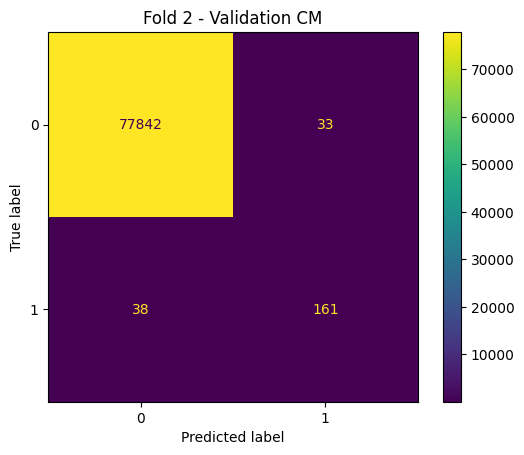



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.8090
Recall: 0.8131
F1 Score: 0.8111
Average Precision: 0.6583
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.81      0.81      0.81       198

    accuracy                           1.00     78073
   macro avg       0.90      0.91      0.91     78073
weighted avg       1.00      1.00      1.00     78073



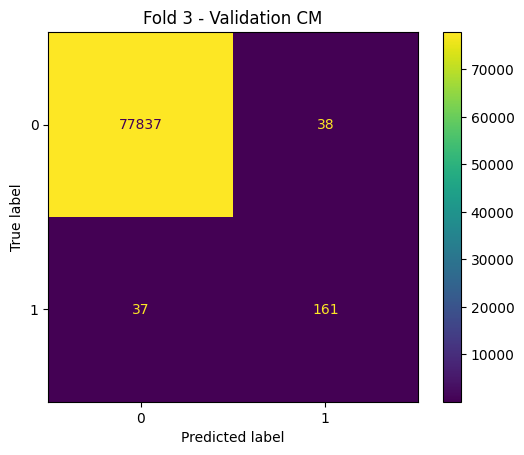



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.8155
Recall: 0.8485
F1 Score: 0.8317
Average Precision: 0.6924
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.82      0.85      0.83       198

    accuracy                           1.00     78073
   macro avg       0.91      0.92      0.92     78073
weighted avg       1.00      1.00      1.00     78073



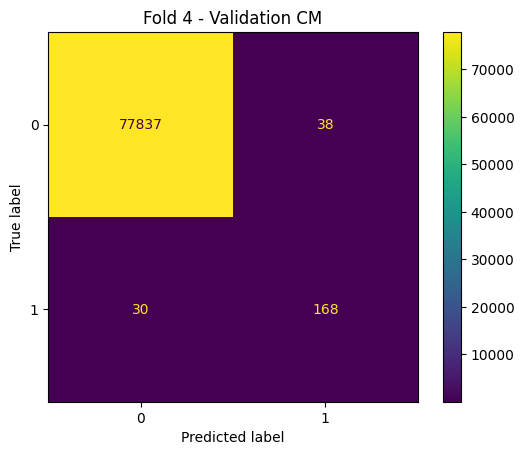



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.8706
Recall: 0.7437
F1 Score: 0.8022
Average Precision: 0.6481
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.87      0.74      0.80       199

    accuracy                           1.00     78073
   macro avg       0.93      0.87      0.90     78073
weighted avg       1.00      1.00      1.00     78073



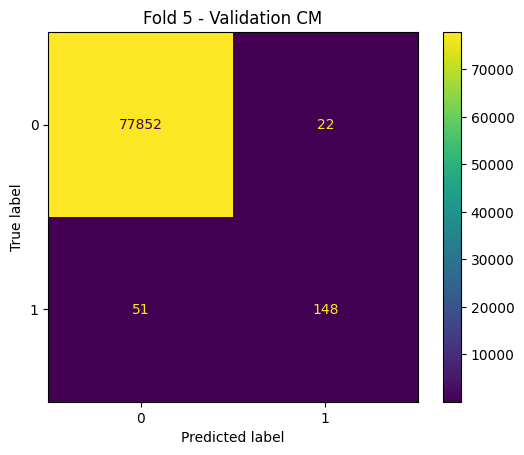


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.8414
avg_recall: 0.8077
avg_f1_score: 0.8232
avg_average_precision: 0.6796

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.8817  0.8241    0.8519         0.7271
Fold 2      0.8299  0.8090    0.8193         0.6719
Fold 3      0.8090  0.8131    0.8111         0.6583
Fold 4      0.8155  0.8485    0.8317         0.6924
Fold 5      0.8706  0.7437    0.8022         0.6481
Average     0.8413  0.8077    0.8232         0.6796


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
avg_dt_scores_s1, dt_model_s1, dt_scores_s1 = evaluate_folds(folds_s1, model=dt_model)
clean_df = format_scores(dt_scores_s1)
print("\n===== Evaluation Summary =====")
print(clean_df)

**Cat Boost training on Scenario 1**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9840
Recall: 0.9296
F1 Score: 0.9561
Average Precision: 0.9850
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.93      0.96       199

    accuracy                           1.00     78074
   macro avg       0.99      0.96      0.98     78074
weighted avg       1.00      1.00      1.00     78074



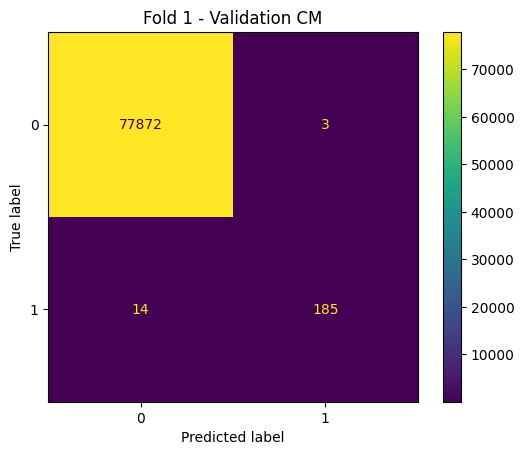



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9592
Recall: 0.9447
F1 Score: 0.9519
Average Precision: 0.9773
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.96      0.94      0.95       199

    accuracy                           1.00     78074
   macro avg       0.98      0.97      0.98     78074
weighted avg       1.00      1.00      1.00     78074



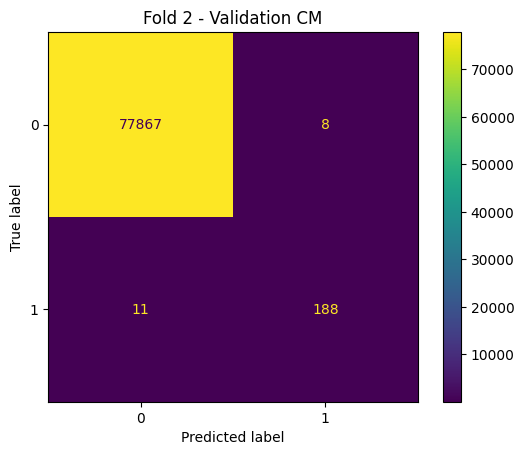



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9728
Recall: 0.9040
F1 Score: 0.9372
Average Precision: 0.9861
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.97      0.90      0.94       198

    accuracy                           1.00     78073
   macro avg       0.99      0.95      0.97     78073
weighted avg       1.00      1.00      1.00     78073



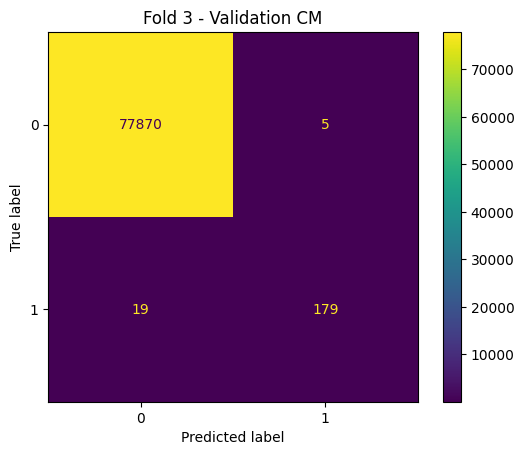



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9692
Recall: 0.9545
F1 Score: 0.9618
Average Precision: 0.9853
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.97      0.95      0.96       198

    accuracy                           1.00     78073
   macro avg       0.98      0.98      0.98     78073
weighted avg       1.00      1.00      1.00     78073



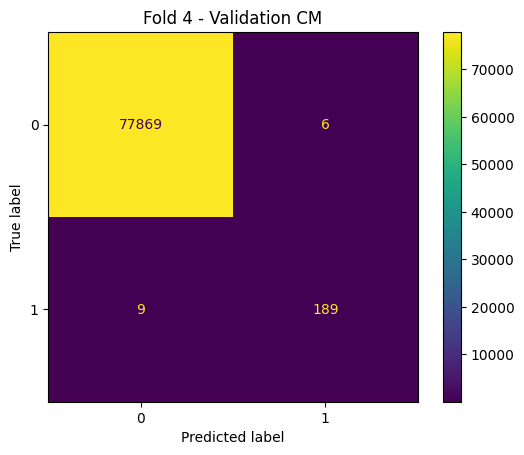



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9840
Recall: 0.9246
F1 Score: 0.9534
Average Precision: 0.9863
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.98      0.92      0.95       199

    accuracy                           1.00     78073
   macro avg       0.99      0.96      0.98     78073
weighted avg       1.00      1.00      1.00     78073



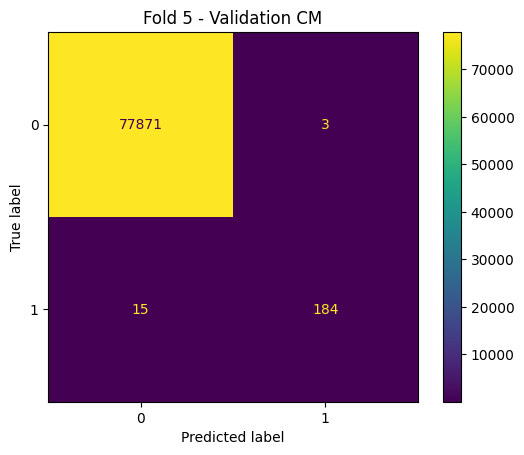


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9738
avg_recall: 0.9315
avg_f1_score: 0.9521
avg_average_precision: 0.9840

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9840  0.9296    0.9561         0.9850
Fold 2      0.9592  0.9447    0.9519         0.9773
Fold 3      0.9728  0.9040    0.9372         0.9861
Fold 4      0.9692  0.9545    0.9618         0.9853
Fold 5      0.9840  0.9246    0.9534         0.9863
Average     0.9738  0.9315    0.9521         0.9840


In [ ]:
cat_model  = CatBoostClassifier(verbose=0, random_state=42)
avg_cat_scores_s1, cat_model_s1, cat_scores_s1  = evaluate_folds(folds_s1, model=cat_model)
clean_df = format_scores(cat_scores_s1)
print("\n===== Evaluation Summary =====")
print(clean_df)

# **Testing on Scenario 1**

**Random Forest testing on Scenario 1**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.9759
Recall: 0.7364
F1 Score: 0.8394
Average Precision: 0.9428
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.98      0.74      0.84       110

    accuracy                           1.00     43375
   macro avg       0.99      0.87      0.92     43375
weighted avg       1.00      1.00      1.00     43375



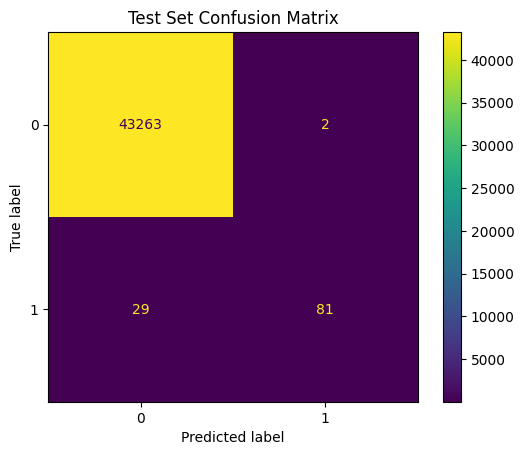

In [ ]:
rf_test_scores_s1 = evaluate_on_test(rf_model_s1, test_s1)

**XGBoost testing on Scenario 1**



=== FINAL TEST EVALUATION ===
Precision: 0.9615
Recall: 0.9091
F1 Score: 0.9346
Average Precision: 0.9839
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.96      0.91      0.93       110

    accuracy                           1.00     43375
   macro avg       0.98      0.95      0.97     43375
weighted avg       1.00      1.00      1.00     43375



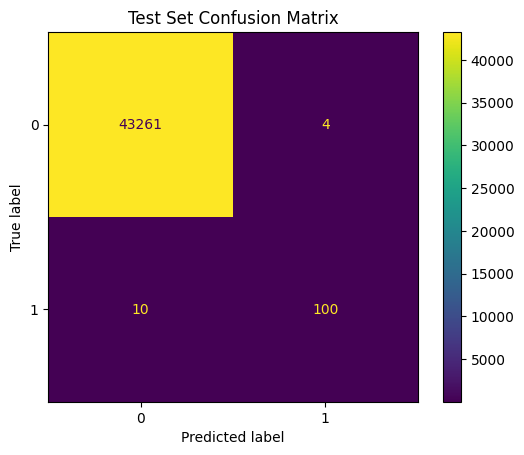

In [ ]:
xgb_test_scores_s1 = evaluate_on_test(xgb_model_s1, test_s1)

**Decision Tree testing on Scenario 1**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.7863
Recall: 0.8364
F1 Score: 0.8106
Average Precision: 0.6581
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.79      0.84      0.81       110

    accuracy                           1.00     43375
   macro avg       0.89      0.92      0.91     43375
weighted avg       1.00      1.00      1.00     43375



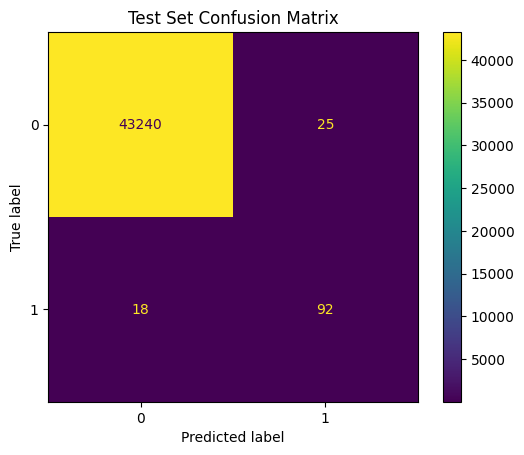

In [ ]:
dt_test_scores_s1 = evaluate_on_test(dt_model_s1, test_s1)

**CatBoost testing on Scenario 1**



=== FINAL TEST EVALUATION ===
Precision: 0.9714
Recall: 0.9273
F1 Score: 0.9488
Average Precision: 0.9909
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.97      0.93      0.95       110

    accuracy                           1.00     43375
   macro avg       0.99      0.96      0.97     43375
weighted avg       1.00      1.00      1.00     43375



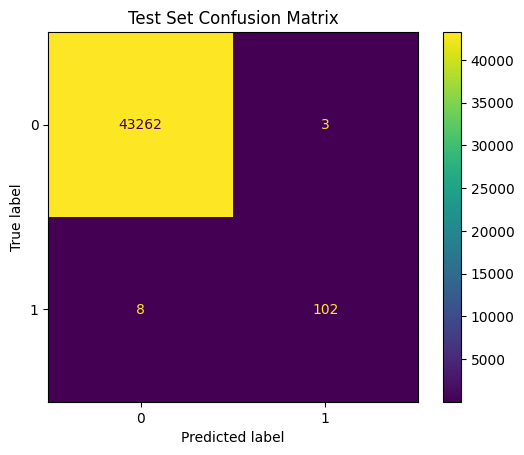

In [ ]:
cat_test_scores_s1 = evaluate_on_test(cat_model_s1, test_s1)

# **Scenario 2: Data With Top 50 Features**

**Top 50 Features using MI and ANOVA**

In [ ]:
session_path = 'session.csv'
df_s2 = pd.read_csv(session_path)
df_s2 = df_s2.drop(columns=['Unnamed: 0','starttime','endtime','sessionid','week'])
folds_s2, test_s2 = create_folds(df_s2, smote=False, undersampling=False, smote_ratio=0.03, undersampling_ratio=0.04)
X_train_s2, y_train_s2, X_val_s2, y_val_s2 = folds_s2[0]
X_test_s2, y_test_s2 = test_s2

<ipython-input-3-9c3d3292ea1f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[~target.isin([0,1])] = 1


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15 31 36 37 38 39 40 41 42 45 52 59 66 73] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


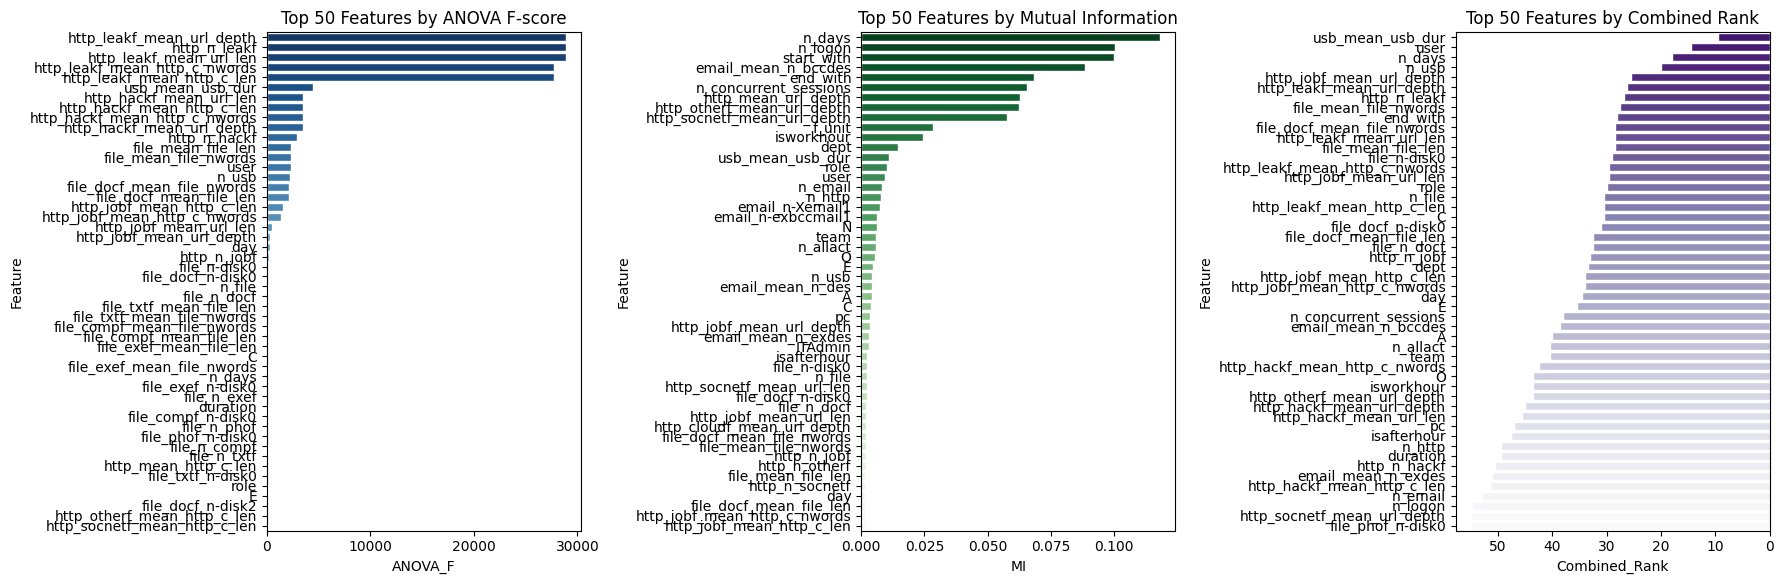

In [ ]:
X_2 = df_s2.drop(columns=['insider'])
y_2 = df_s2['insider']
top_features = rank_and_plot_top_features(X_2, y_2, top_k=50)

In [ ]:
folds_2_top50 = [
    [X_train_s2[top_features], y_train_s2, X_val_s2[top_features], y_val_s2]
    for X_train, y_train, X_val, y_val in folds_s2
]

X_test_s2, y_test_s2 = test_s2
X_test_top50 = X_test_s2[top_features]
test_data_s2 = [X_test_top50, y_test_s2]

# **Training on Scenario 2**

**Random Forest training on Scenario 2**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9868
Recall: 0.7487
F1 Score: 0.8514
Average Precision: 0.9544
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.75      0.85       199

    accuracy                           1.00     78074
   macro avg       0.99      0.87      0.93     78074
weighted avg       1.00      1.00      1.00     78074



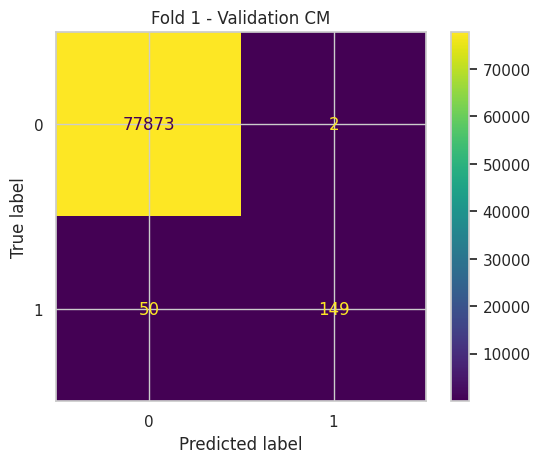



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9868
Recall: 0.7487
F1 Score: 0.8514
Average Precision: 0.9544
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.75      0.85       199

    accuracy                           1.00     78074
   macro avg       0.99      0.87      0.93     78074
weighted avg       1.00      1.00      1.00     78074



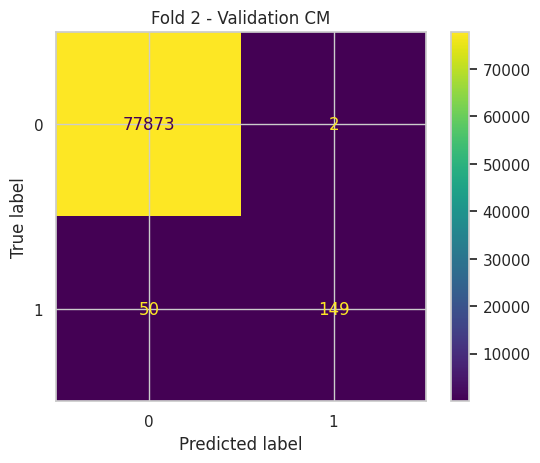



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9868
Recall: 0.7487
F1 Score: 0.8514
Average Precision: 0.9544
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.75      0.85       199

    accuracy                           1.00     78074
   macro avg       0.99      0.87      0.93     78074
weighted avg       1.00      1.00      1.00     78074



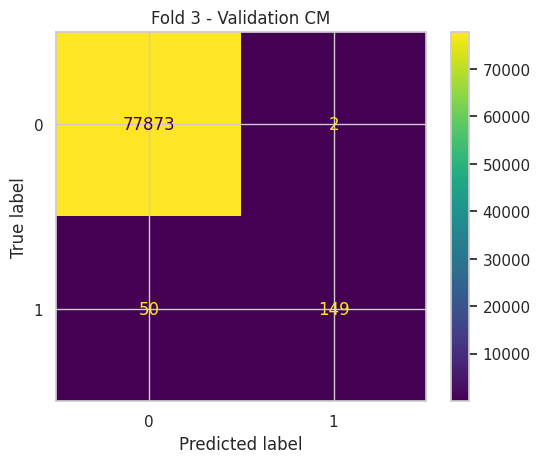



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9868
Recall: 0.7487
F1 Score: 0.8514
Average Precision: 0.9544
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.75      0.85       199

    accuracy                           1.00     78074
   macro avg       0.99      0.87      0.93     78074
weighted avg       1.00      1.00      1.00     78074



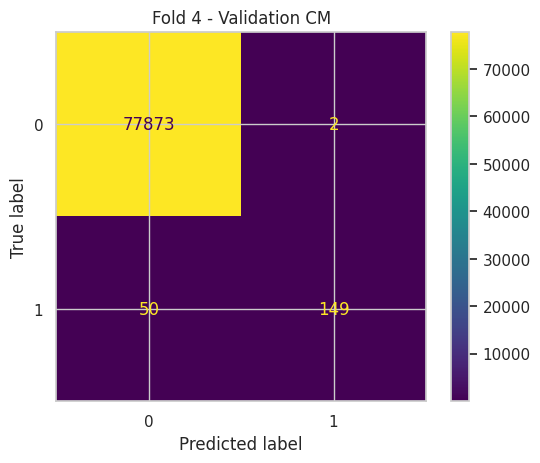



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9868
Recall: 0.7487
F1 Score: 0.8514
Average Precision: 0.9544
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.75      0.85       199

    accuracy                           1.00     78074
   macro avg       0.99      0.87      0.93     78074
weighted avg       1.00      1.00      1.00     78074



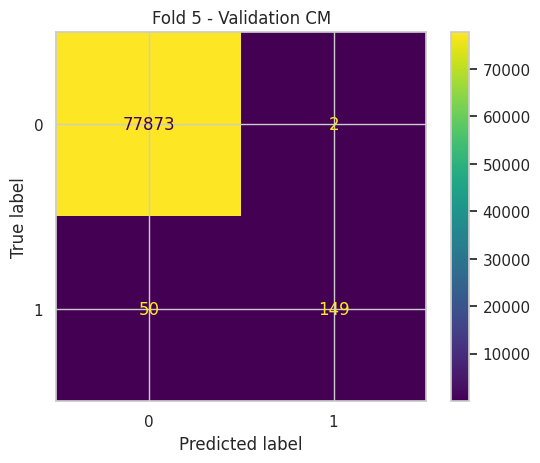


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9868
avg_recall: 0.7487
avg_f1_score: 0.8514
avg_average_precision: 0.9544

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9868  0.7487    0.8514         0.9544
Fold 2      0.9868  0.7487    0.8514         0.9544
Fold 3      0.9868  0.7487    0.8514         0.9544
Fold 4      0.9868  0.7487    0.8514         0.9544
Fold 5      0.9868  0.7487    0.8514         0.9544
Average     0.9868  0.7487    0.8514         0.9544


In [ ]:
# Train Random Forest model on the folds and evaluate
rf_model = RandomForestClassifier(random_state=42)
avg_rf_scores_s2, rf_model_s2, rf_scores_s2 = evaluate_folds(folds_2_top50, model=rf_model)
clean_df = format_scores(rf_scores_s2)
print("\n===== Evaluation Summary =====")
print(clean_df)

**XG Boost training on Scenario 2**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9834
Recall: 0.8945
F1 Score: 0.9368
Average Precision: 0.9833
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.89      0.94       199

    accuracy                           1.00     78074
   macro avg       0.99      0.95      0.97     78074
weighted avg       1.00      1.00      1.00     78074



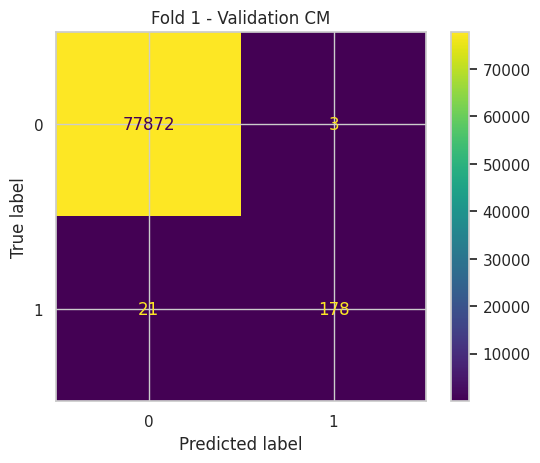



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9834
Recall: 0.8945
F1 Score: 0.9368
Average Precision: 0.9833
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.89      0.94       199

    accuracy                           1.00     78074
   macro avg       0.99      0.95      0.97     78074
weighted avg       1.00      1.00      1.00     78074



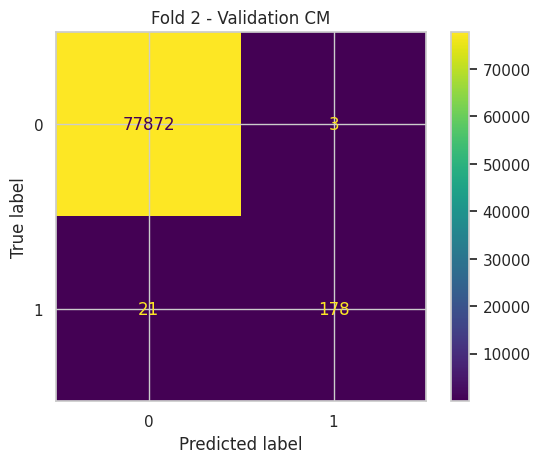



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9834
Recall: 0.8945
F1 Score: 0.9368
Average Precision: 0.9833
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.89      0.94       199

    accuracy                           1.00     78074
   macro avg       0.99      0.95      0.97     78074
weighted avg       1.00      1.00      1.00     78074



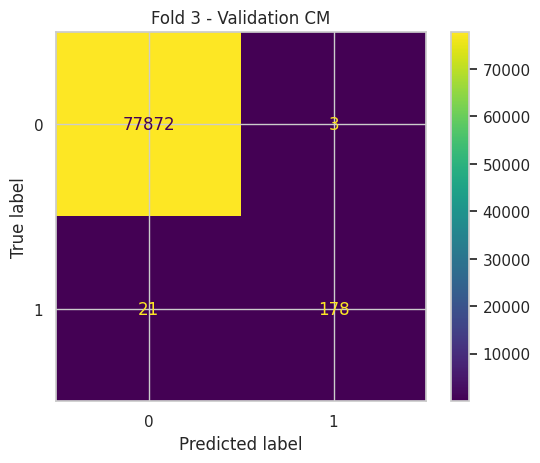



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9834
Recall: 0.8945
F1 Score: 0.9368
Average Precision: 0.9833
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.89      0.94       199

    accuracy                           1.00     78074
   macro avg       0.99      0.95      0.97     78074
weighted avg       1.00      1.00      1.00     78074



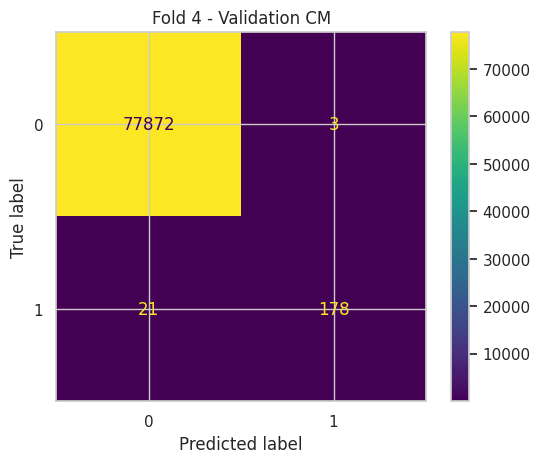



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9834
Recall: 0.8945
F1 Score: 0.9368
Average Precision: 0.9833
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.89      0.94       199

    accuracy                           1.00     78074
   macro avg       0.99      0.95      0.97     78074
weighted avg       1.00      1.00      1.00     78074



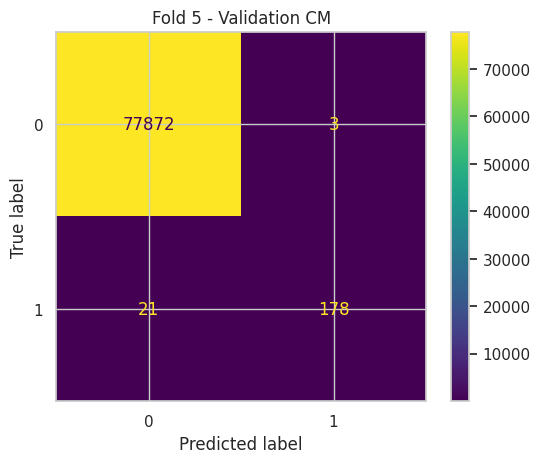


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9834
avg_recall: 0.8945
avg_f1_score: 0.9368
avg_average_precision: 0.9833

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9834  0.8945    0.9368         0.9833
Fold 2      0.9834  0.8945    0.9368         0.9833
Fold 3      0.9834  0.8945    0.9368         0.9833
Fold 4      0.9834  0.8945    0.9368         0.9833
Fold 5      0.9834  0.8945    0.9368         0.9833
Average     0.9834  0.8945    0.9368         0.9833


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
avg_xgb_scores_s2, xgb_model_s2, xgb_scores_s2 = evaluate_folds(folds_2_top50, model=xgb_model)
clean_df = format_scores(xgb_scores_s2)
print("\n===== Evaluation Summary =====")
print(clean_df)

**Decision Tree training on Scenario 2**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.8333
Recall: 0.8543
F1 Score: 0.8437
Average Precision: 0.7123
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.83      0.85      0.84       199

    accuracy                           1.00     78074
   macro avg       0.92      0.93      0.92     78074
weighted avg       1.00      1.00      1.00     78074



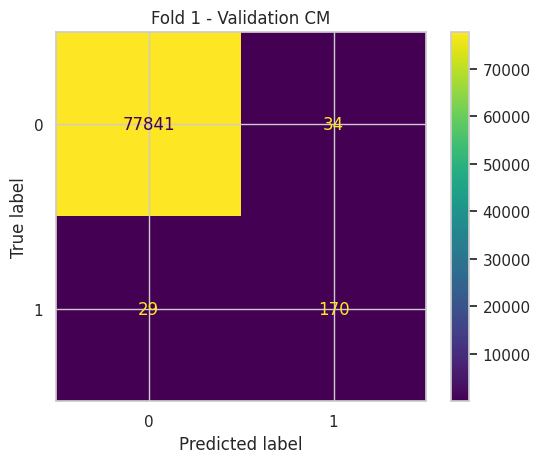



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.8333
Recall: 0.8543
F1 Score: 0.8437
Average Precision: 0.7123
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.83      0.85      0.84       199

    accuracy                           1.00     78074
   macro avg       0.92      0.93      0.92     78074
weighted avg       1.00      1.00      1.00     78074



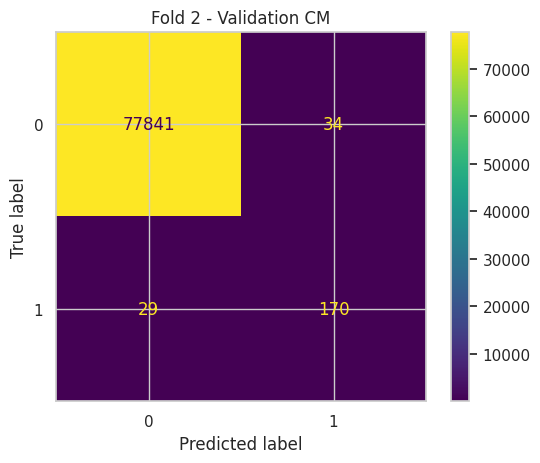



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.8333
Recall: 0.8543
F1 Score: 0.8437
Average Precision: 0.7123
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.83      0.85      0.84       199

    accuracy                           1.00     78074
   macro avg       0.92      0.93      0.92     78074
weighted avg       1.00      1.00      1.00     78074



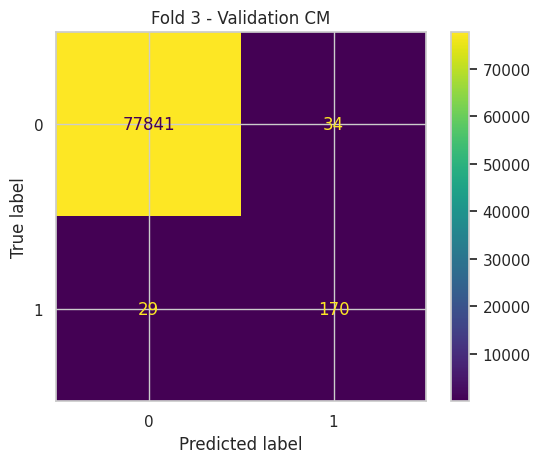



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.8333
Recall: 0.8543
F1 Score: 0.8437
Average Precision: 0.7123
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.83      0.85      0.84       199

    accuracy                           1.00     78074
   macro avg       0.92      0.93      0.92     78074
weighted avg       1.00      1.00      1.00     78074



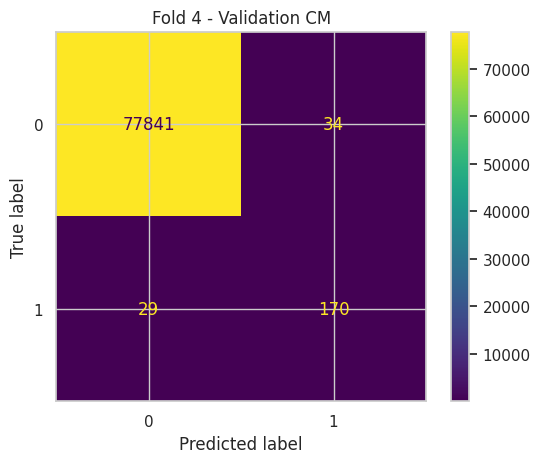



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.8333
Recall: 0.8543
F1 Score: 0.8437
Average Precision: 0.7123
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.83      0.85      0.84       199

    accuracy                           1.00     78074
   macro avg       0.92      0.93      0.92     78074
weighted avg       1.00      1.00      1.00     78074



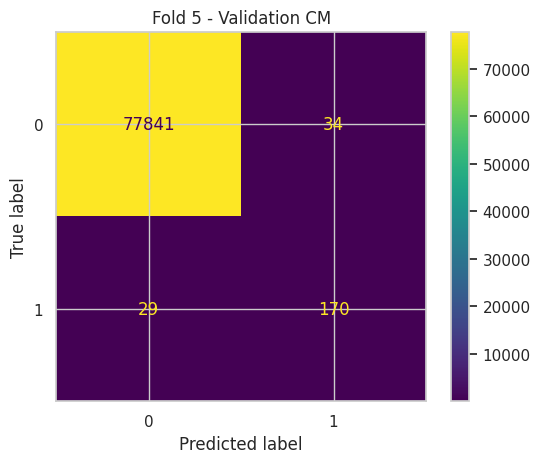


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.8333
avg_recall: 0.8543
avg_f1_score: 0.8437
avg_average_precision: 0.7123

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.8333  0.8543    0.8437         0.7123
Fold 2      0.8333  0.8543    0.8437         0.7123
Fold 3      0.8333  0.8543    0.8437         0.7123
Fold 4      0.8333  0.8543    0.8437         0.7123
Fold 5      0.8333  0.8543    0.8437         0.7123
Average     0.8333  0.8543    0.8437         0.7123


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
avg_dt_scores_s2, dt_model_s2, dt_scores_s2 = evaluate_folds(folds_2_top50, model=dt_model)
clean_df = format_scores(dt_scores_s2)
print("\n===== Evaluation Summary =====")
print(clean_df)

**CatBoost training on Scenario 2**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9946
Recall: 0.9296
F1 Score: 0.9610
Average Precision: 0.9893
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.93      0.96       199

    accuracy                           1.00     78074
   macro avg       1.00      0.96      0.98     78074
weighted avg       1.00      1.00      1.00     78074



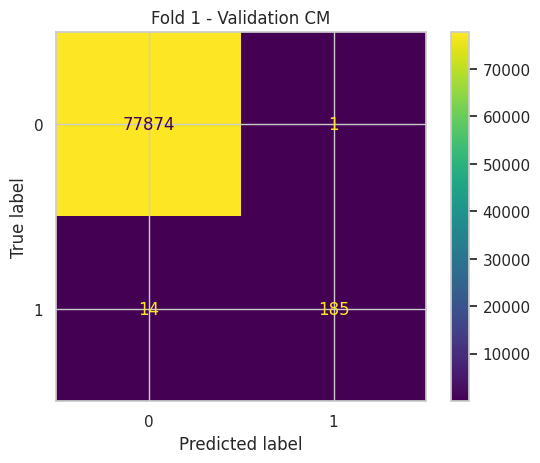



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9946
Recall: 0.9296
F1 Score: 0.9610
Average Precision: 0.9893
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.93      0.96       199

    accuracy                           1.00     78074
   macro avg       1.00      0.96      0.98     78074
weighted avg       1.00      1.00      1.00     78074



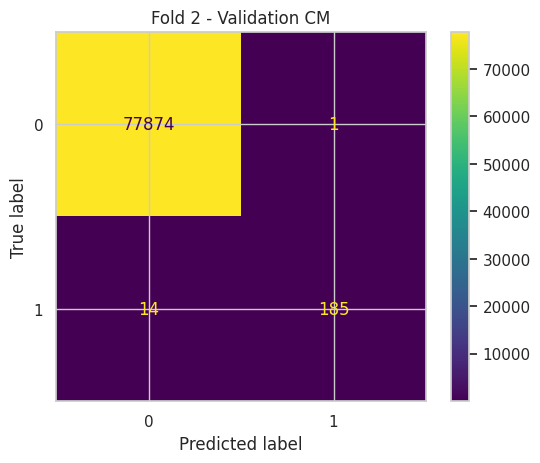



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9946
Recall: 0.9296
F1 Score: 0.9610
Average Precision: 0.9893
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.93      0.96       199

    accuracy                           1.00     78074
   macro avg       1.00      0.96      0.98     78074
weighted avg       1.00      1.00      1.00     78074



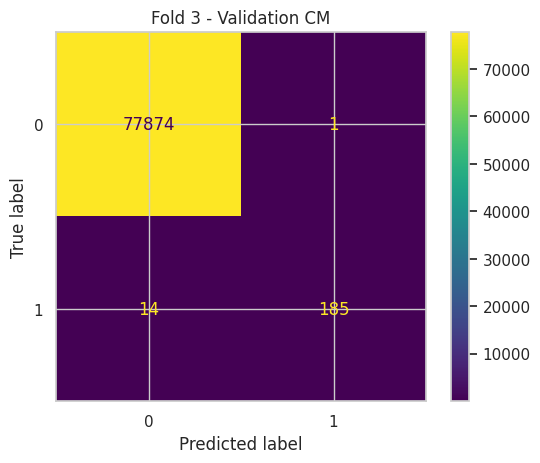



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9946
Recall: 0.9296
F1 Score: 0.9610
Average Precision: 0.9893
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.93      0.96       199

    accuracy                           1.00     78074
   macro avg       1.00      0.96      0.98     78074
weighted avg       1.00      1.00      1.00     78074



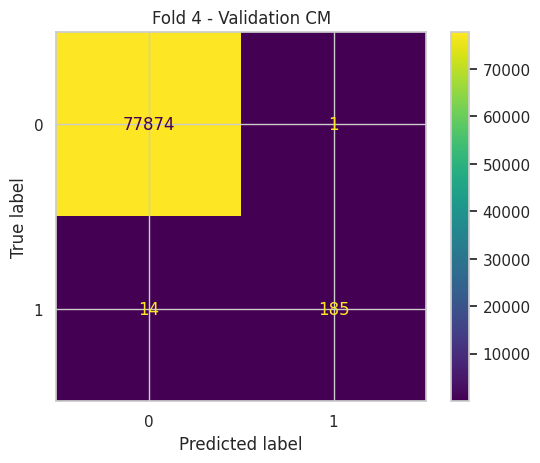



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9946
Recall: 0.9296
F1 Score: 0.9610
Average Precision: 0.9893
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.99      0.93      0.96       199

    accuracy                           1.00     78074
   macro avg       1.00      0.96      0.98     78074
weighted avg       1.00      1.00      1.00     78074



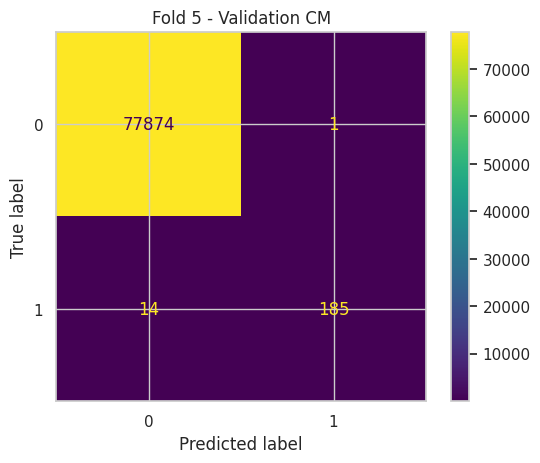


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9946
avg_recall: 0.9296
avg_f1_score: 0.9610
avg_average_precision: 0.9893

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9946  0.9296     0.961         0.9893
Fold 2      0.9946  0.9296     0.961         0.9893
Fold 3      0.9946  0.9296     0.961         0.9893
Fold 4      0.9946  0.9296     0.961         0.9893
Fold 5      0.9946  0.9296     0.961         0.9893
Average     0.9946  0.9296     0.961         0.9893


In [ ]:
cat_model  = CatBoostClassifier(verbose=0, random_state=42)
avg_cat_scores_s2, cat_model_s2, cat_scores_s2  = evaluate_folds(folds_2_top50, model=cat_model)
clean_df = format_scores(cat_scores_s2)
print("\n===== Evaluation Summary =====")
print(clean_df)

# **Testing on Scenario 2**

**Random Forest testing on Scenario 2**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.9770
Recall: 0.7727
F1 Score: 0.8629
Average Precision: 0.9541
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.98      0.77      0.86       110

    accuracy                           1.00     43375
   macro avg       0.99      0.89      0.93     43375
weighted avg       1.00      1.00      1.00     43375



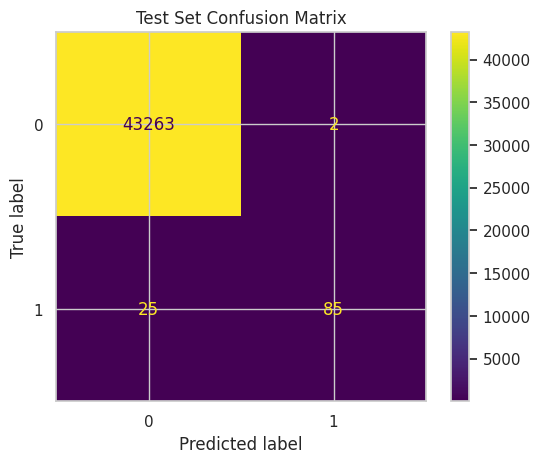

In [ ]:
rf_test_scores_s2 = evaluate_on_test(rf_model_s2, test_data_s2)

**XGBoost testing on Scenario 2**



=== FINAL TEST EVALUATION ===
Precision: 0.9600
Recall: 0.8727
F1 Score: 0.9143
Average Precision: 0.9891
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.96      0.87      0.91       110

    accuracy                           1.00     43375
   macro avg       0.98      0.94      0.96     43375
weighted avg       1.00      1.00      1.00     43375



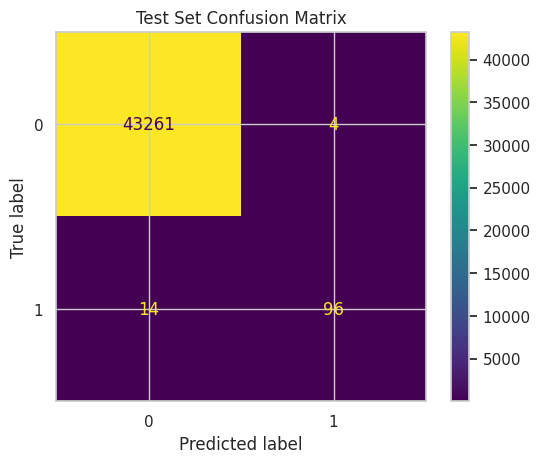

In [ ]:
xgb_test_scores_s2 = evaluate_on_test(xgb_model_s2, test_data_s2)

**Decision Tree testing on Scenario 2**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.8333
Recall: 0.8182
F1 Score: 0.8257
Average Precision: 0.6823
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.83      0.82      0.83       110

    accuracy                           1.00     43375
   macro avg       0.92      0.91      0.91     43375
weighted avg       1.00      1.00      1.00     43375



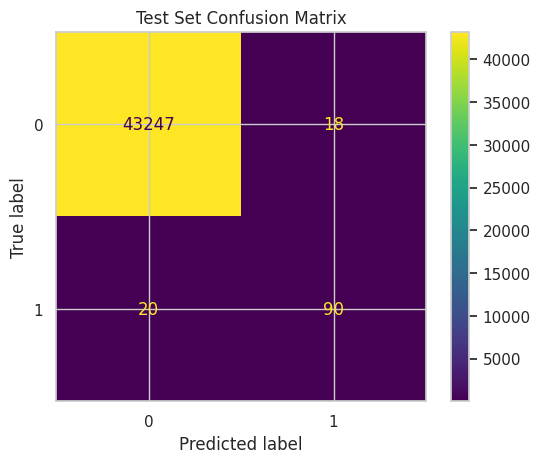

In [ ]:
dt_test_scores_s2 = evaluate_on_test(dt_model_s2, test_data_s2)

**CatBoost testing on Scenario 2**



=== FINAL TEST EVALUATION ===
Precision: 0.9633
Recall: 0.9545
F1 Score: 0.9589
Average Precision: 0.9942
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.96      0.95      0.96       110

    accuracy                           1.00     43375
   macro avg       0.98      0.98      0.98     43375
weighted avg       1.00      1.00      1.00     43375



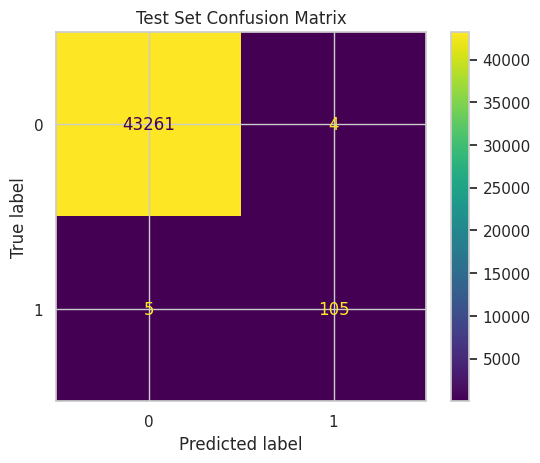

In [ ]:
cat_test_scores_s2 = evaluate_on_test(cat_model_s2, test_data_s2)

# **Scenario 3: SMOTE & Undersampling**

In [ ]:
session_path = 'session.csv'
df_s3 = pd.read_csv(session_path)
df_s3 = df_s3.drop(columns=['Unnamed: 0','starttime','endtime','sessionid','week'])
folds_s3, test_s3 = create_folds(df_s3, smote=True, undersampling=True, smote_ratio=0.03, undersampling_ratio=0.04)
X_train_s3, y_train_s3, X_val_s3, y_val_s3 = folds_s3[0]
X_test_s3, y_test_s3 = test_s3

<ipython-input-3-9c3d3292ea1f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[~target.isin([0,1])] = 1


# **Training on Scenario 3**

**Random Forest training on Scenario 3**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9045
Recall: 0.7136
F1 Score: 0.7978
Average Precision: 0.9045
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.90      0.71      0.80       199

    accuracy                           1.00     78074
   macro avg       0.95      0.86      0.90     78074
weighted avg       1.00      1.00      1.00     78074



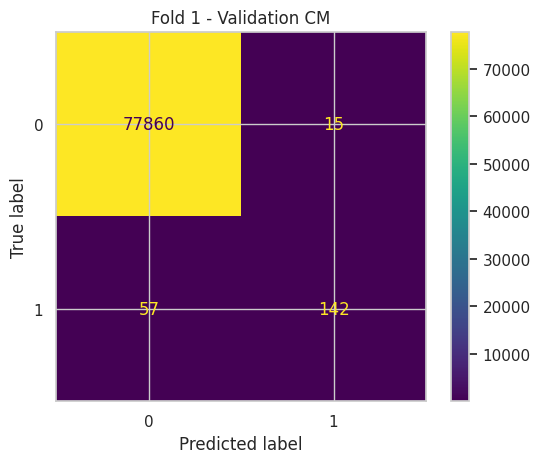



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9392
Recall: 0.6985
F1 Score: 0.8012
Average Precision: 0.8857
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.94      0.70      0.80       199

    accuracy                           1.00     78074
   macro avg       0.97      0.85      0.90     78074
weighted avg       1.00      1.00      1.00     78074



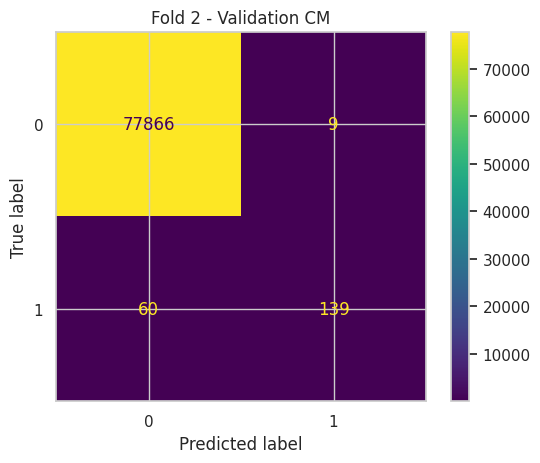



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9007
Recall: 0.6869
F1 Score: 0.7794
Average Precision: 0.8889
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.90      0.69      0.78       198

    accuracy                           1.00     78073
   macro avg       0.95      0.84      0.89     78073
weighted avg       1.00      1.00      1.00     78073



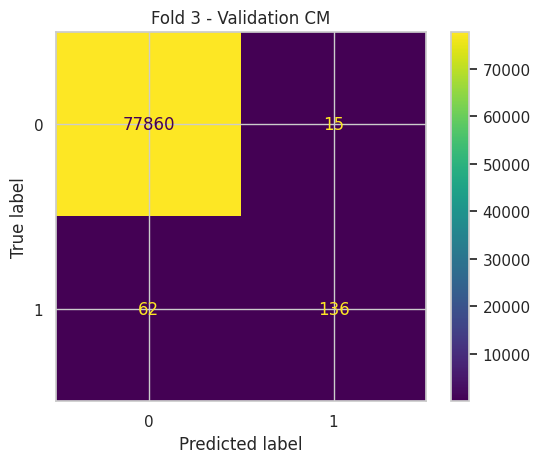



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9272
Recall: 0.7071
F1 Score: 0.8023
Average Precision: 0.9159
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.93      0.71      0.80       198

    accuracy                           1.00     78073
   macro avg       0.96      0.85      0.90     78073
weighted avg       1.00      1.00      1.00     78073



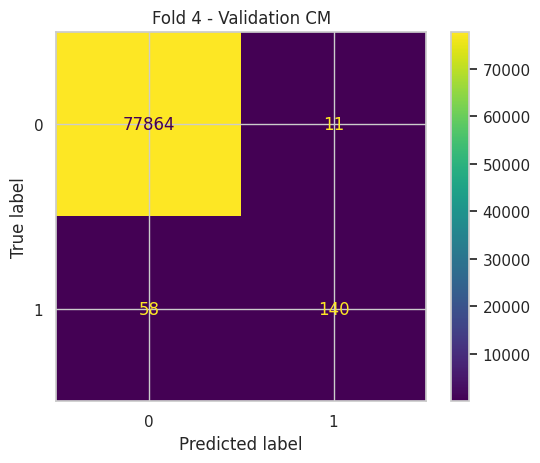



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9125
Recall: 0.7337
F1 Score: 0.8134
Average Precision: 0.8916
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.91      0.73      0.81       199

    accuracy                           1.00     78073
   macro avg       0.96      0.87      0.91     78073
weighted avg       1.00      1.00      1.00     78073



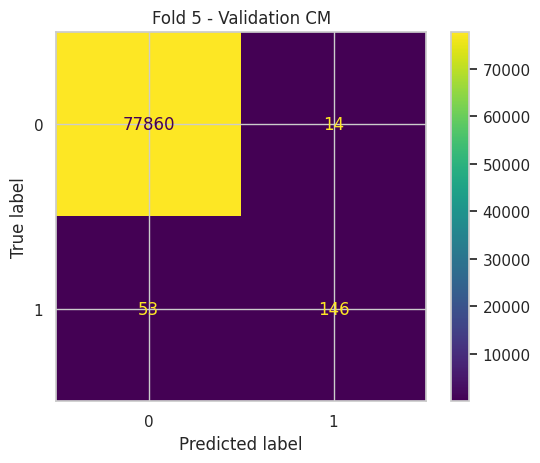


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9168
avg_recall: 0.7079
avg_f1_score: 0.7988
avg_average_precision: 0.8973

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9045  0.7136    0.7978         0.9045
Fold 2      0.9392  0.6985    0.8012         0.8857
Fold 3      0.9007  0.6869    0.7794         0.8889
Fold 4      0.9272  0.7071    0.8023         0.9159
Fold 5      0.9125  0.7337    0.8134         0.8916
Average     0.9168  0.7080    0.7988         0.8973


In [ ]:
# Train Random Forest model on the folds and evaluate
rf_model = RandomForestClassifier(random_state=42)
avg_rf_scores_s3, rf_model_s3, rf_scores_s3 = evaluate_folds(folds_s3, model=rf_model)
clean_df = format_scores(rf_scores_s3)
print("\n===== Evaluation Summary =====")
print(clean_df)

**XGB Classifier training on Scenario 3**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9282
Recall: 0.9095
F1 Score: 0.9188
Average Precision: 0.9775
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.93      0.91      0.92       199

    accuracy                           1.00     78074
   macro avg       0.96      0.95      0.96     78074
weighted avg       1.00      1.00      1.00     78074



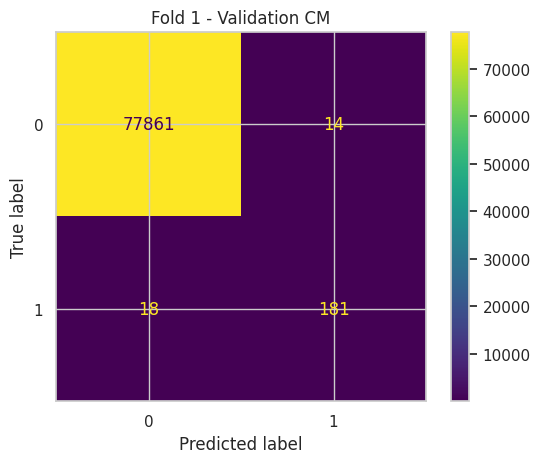



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9208
Recall: 0.9347
F1 Score: 0.9277
Average Precision: 0.9694
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.92      0.93      0.93       199

    accuracy                           1.00     78074
   macro avg       0.96      0.97      0.96     78074
weighted avg       1.00      1.00      1.00     78074



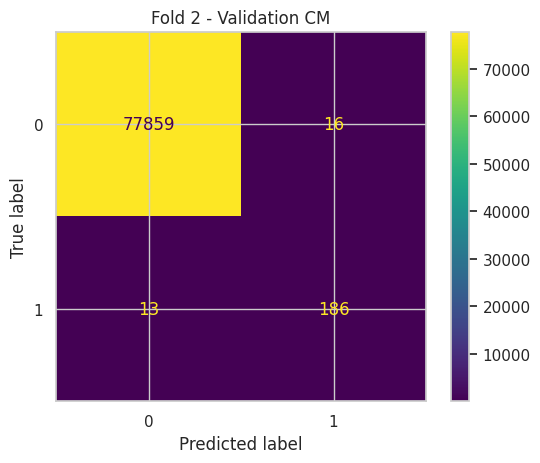



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9029
Recall: 0.9394
F1 Score: 0.9208
Average Precision: 0.9697
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.90      0.94      0.92       198

    accuracy                           1.00     78073
   macro avg       0.95      0.97      0.96     78073
weighted avg       1.00      1.00      1.00     78073



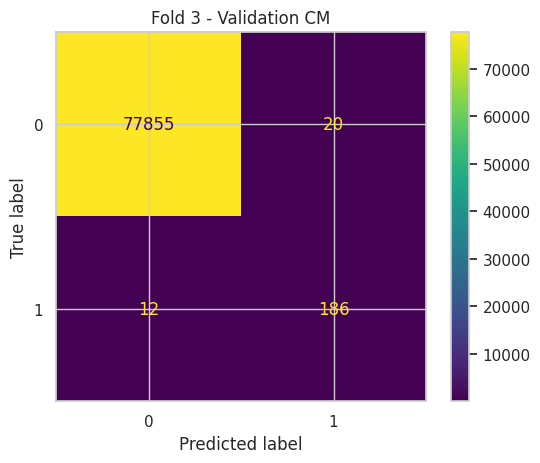



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9146
Recall: 0.9192
F1 Score: 0.9169
Average Precision: 0.9750
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.91      0.92      0.92       198

    accuracy                           1.00     78073
   macro avg       0.96      0.96      0.96     78073
weighted avg       1.00      1.00      1.00     78073



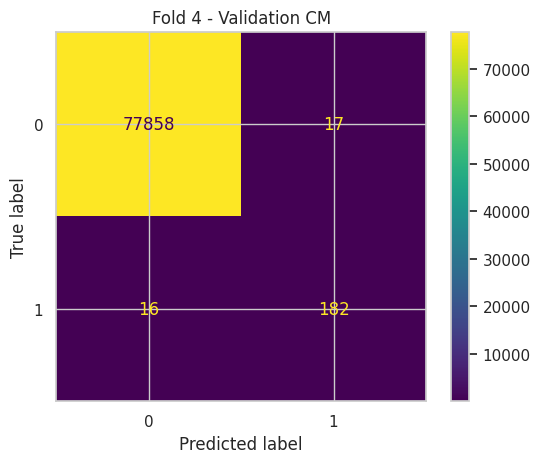



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9188
Recall: 0.9095
F1 Score: 0.9141
Average Precision: 0.9653
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.92      0.91      0.91       199

    accuracy                           1.00     78073
   macro avg       0.96      0.95      0.96     78073
weighted avg       1.00      1.00      1.00     78073



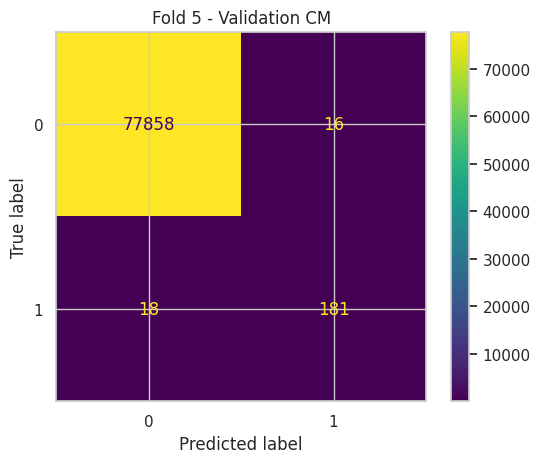


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9171
avg_recall: 0.9225
avg_f1_score: 0.9197
avg_average_precision: 0.9714

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9282  0.9095    0.9188         0.9775
Fold 2      0.9208  0.9347    0.9277         0.9694
Fold 3      0.9029  0.9394    0.9208         0.9697
Fold 4      0.9146  0.9192    0.9169         0.9750
Fold 5      0.9188  0.9095    0.9141         0.9653
Average     0.9171  0.9225    0.9197         0.9714


In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
avg_xgb_scores_s3, xgb_model_s3, xgb_scores_s3 = evaluate_folds(folds_s3, model=xgb_model)
clean_df = format_scores(xgb_scores_s3)
print("\n===== Evaluation Summary =====")
print(clean_df)

**Decision Tree Classifier training on Scenario 3**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.6452
Recall: 0.8040
F1 Score: 0.7159
Average Precision: 0.5192
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.65      0.80      0.72       199

    accuracy                           1.00     78074
   macro avg       0.82      0.90      0.86     78074
weighted avg       1.00      1.00      1.00     78074



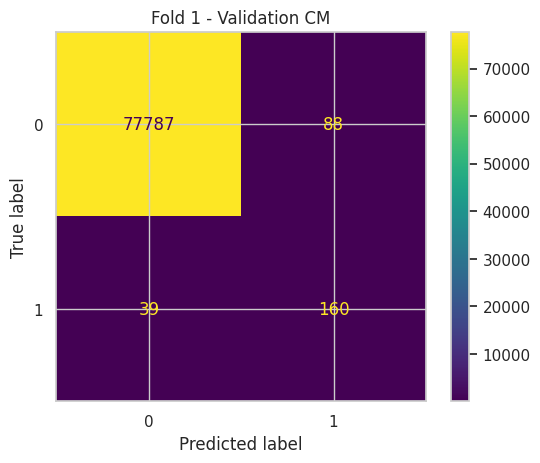



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.6486
Recall: 0.8442
F1 Score: 0.7336
Average Precision: 0.5480
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.65      0.84      0.73       199

    accuracy                           1.00     78074
   macro avg       0.82      0.92      0.87     78074
weighted avg       1.00      1.00      1.00     78074



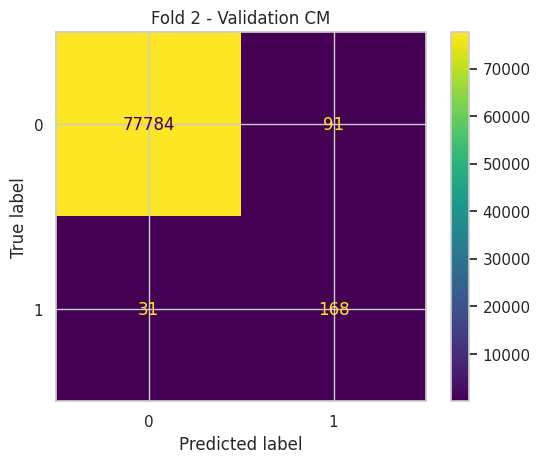



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.6301
Recall: 0.7828
F1 Score: 0.6982
Average Precision: 0.4938
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.63      0.78      0.70       198

    accuracy                           1.00     78073
   macro avg       0.81      0.89      0.85     78073
weighted avg       1.00      1.00      1.00     78073



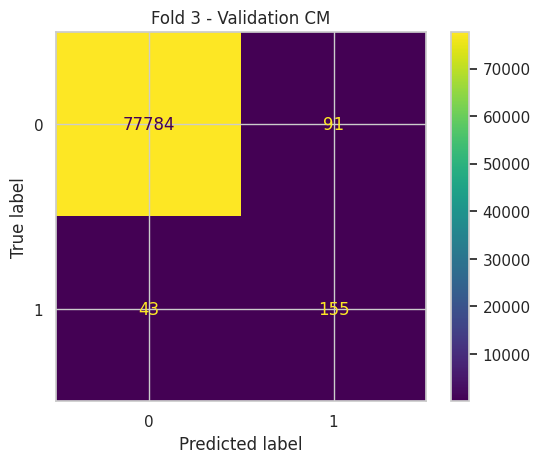



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.7052
Recall: 0.8939
F1 Score: 0.7884
Average Precision: 0.6307
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.71      0.89      0.79       198

    accuracy                           1.00     78073
   macro avg       0.85      0.95      0.89     78073
weighted avg       1.00      1.00      1.00     78073



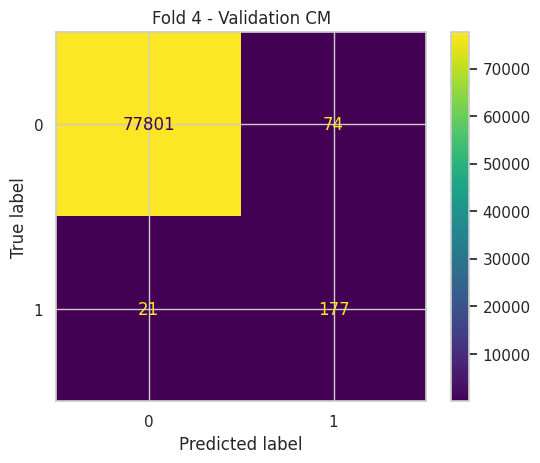



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.6543
Recall: 0.7990
F1 Score: 0.7195
Average Precision: 0.5233
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.65      0.80      0.72       199

    accuracy                           1.00     78073
   macro avg       0.83      0.90      0.86     78073
weighted avg       1.00      1.00      1.00     78073



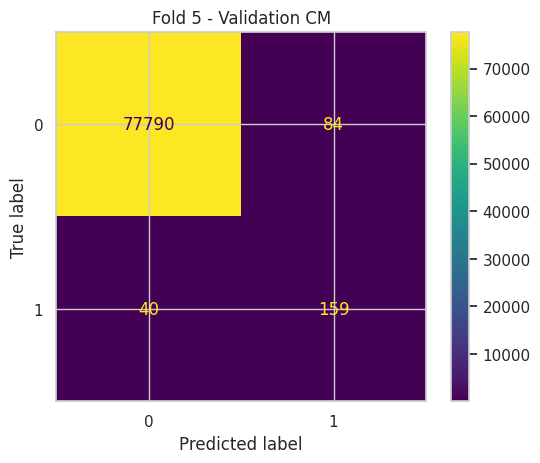


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.6567
avg_recall: 0.8248
avg_f1_score: 0.7311
avg_average_precision: 0.5430

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.6452  0.8040    0.7159         0.5192
Fold 2      0.6486  0.8442    0.7336         0.5480
Fold 3      0.6301  0.7828    0.6982         0.4938
Fold 4      0.7052  0.8939    0.7884         0.6307
Fold 5      0.6543  0.7990    0.7195         0.5233
Average     0.6567  0.8248    0.7311         0.5430


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
avg_dt_scores_s3, dt_model_s3, dt_scores_s3 = evaluate_folds(folds_s3, model=dt_model)
clean_df = format_scores(dt_scores_s3)
print("\n===== Evaluation Summary =====")
print(clean_df)

**CatBoost Model training on Scenario 3**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9394
Recall: 0.9347
F1 Score: 0.9370
Average Precision: 0.9806
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.94      0.93      0.94       199

    accuracy                           1.00     78074
   macro avg       0.97      0.97      0.97     78074
weighted avg       1.00      1.00      1.00     78074



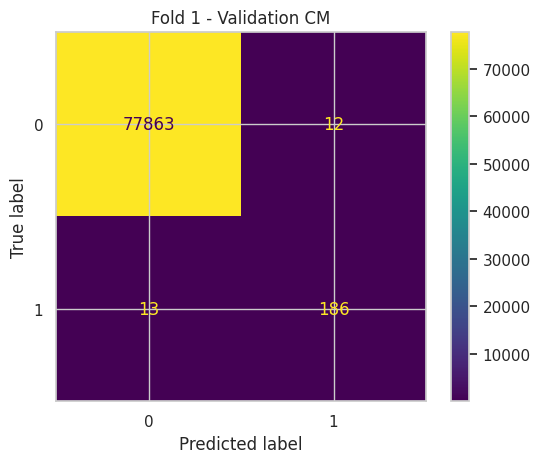



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9122
Recall: 0.9397
F1 Score: 0.9257
Average Precision: 0.9655
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.91      0.94      0.93       199

    accuracy                           1.00     78074
   macro avg       0.96      0.97      0.96     78074
weighted avg       1.00      1.00      1.00     78074



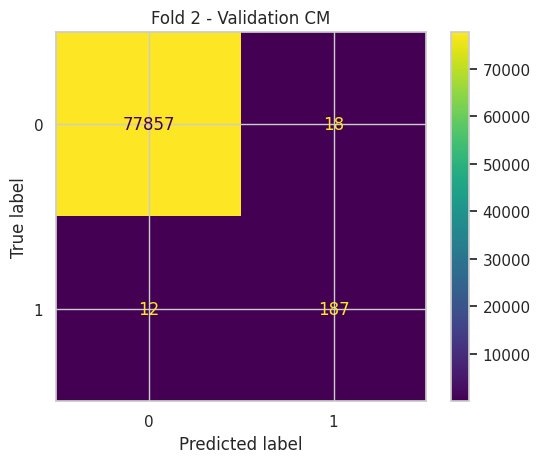



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9043
Recall: 0.9545
F1 Score: 0.9287
Average Precision: 0.9728
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.90      0.95      0.93       198

    accuracy                           1.00     78073
   macro avg       0.95      0.98      0.96     78073
weighted avg       1.00      1.00      1.00     78073



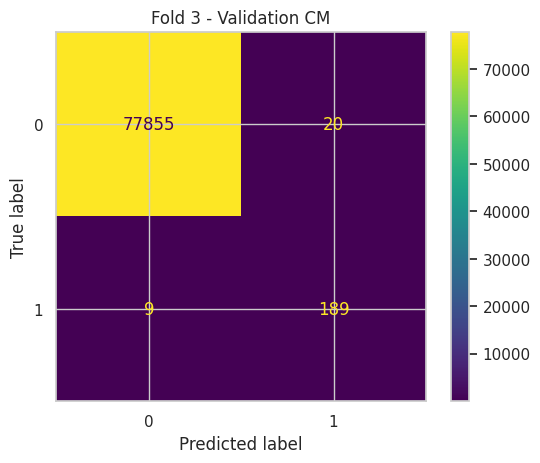



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9082
Recall: 0.9495
F1 Score: 0.9284
Average Precision: 0.9759
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.91      0.95      0.93       198

    accuracy                           1.00     78073
   macro avg       0.95      0.97      0.96     78073
weighted avg       1.00      1.00      1.00     78073



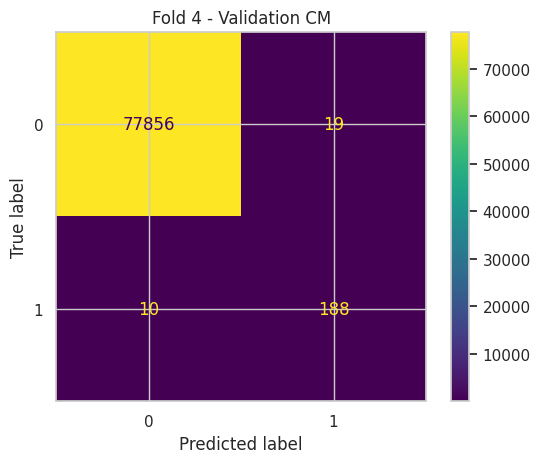



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9326
Recall: 0.9045
F1 Score: 0.9184
Average Precision: 0.9671
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.93      0.90      0.92       199

    accuracy                           1.00     78073
   macro avg       0.97      0.95      0.96     78073
weighted avg       1.00      1.00      1.00     78073



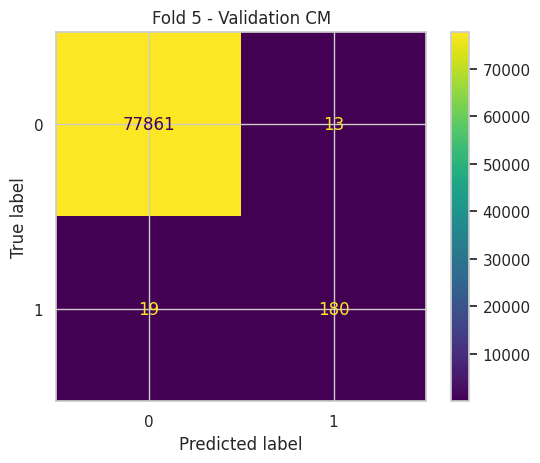


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9194
avg_recall: 0.9366
avg_f1_score: 0.9277
avg_average_precision: 0.9724

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9394  0.9347    0.9370         0.9806
Fold 2      0.9122  0.9397    0.9257         0.9655
Fold 3      0.9043  0.9545    0.9287         0.9728
Fold 4      0.9082  0.9495    0.9284         0.9759
Fold 5      0.9326  0.9045    0.9184         0.9671
Average     0.9193  0.9366    0.9276         0.9724


In [ ]:
cat_model  = CatBoostClassifier(verbose=0, random_state=42)
avg_cat_scores_s3, cat_model_s3, cat_scores_s3  = evaluate_folds(folds_s3, model=cat_model)
clean_df = format_scores(cat_scores_s3)
print("\n===== Evaluation Summary =====")
print(clean_df)

# **Testing on Scenario 3**

**Random Forest testing on Scenario 3**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.9880
Recall: 0.7455
F1 Score: 0.8497
Average Precision: 0.9378
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.99      0.75      0.85       110

    accuracy                           1.00     43375
   macro avg       0.99      0.87      0.92     43375
weighted avg       1.00      1.00      1.00     43375



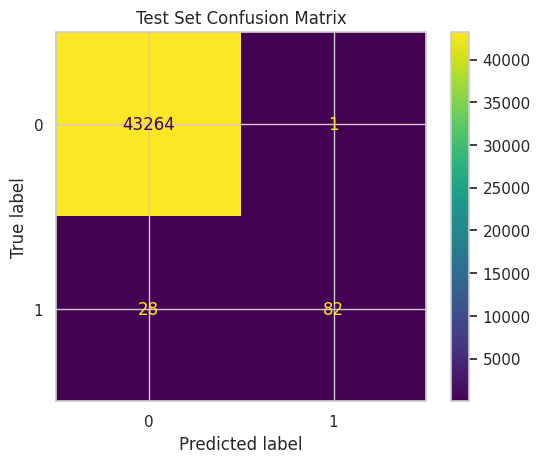

In [ ]:
rf_test_scores_s3 = evaluate_on_test(rf_model_s3, test_s3)

**XGB Classifier testing on Scenario 3**



=== FINAL TEST EVALUATION ===
Precision: 0.9802
Recall: 0.9000
F1 Score: 0.9384
Average Precision: 0.9744
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.98      0.90      0.94       110

    accuracy                           1.00     43375
   macro avg       0.99      0.95      0.97     43375
weighted avg       1.00      1.00      1.00     43375



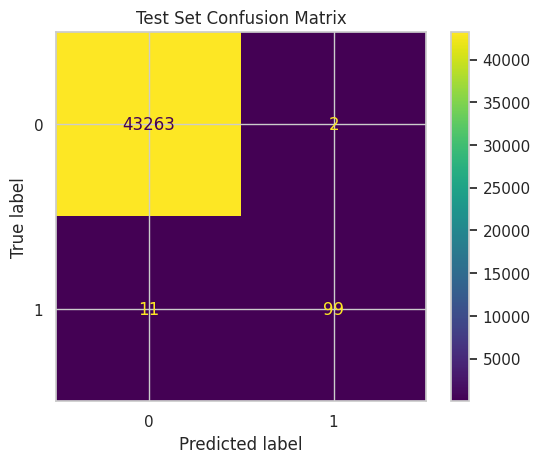

In [ ]:
xgb_test_scores_s3 = evaluate_on_test(xgb_model_s3, test_s3)

**Decision Tree testing on Scenario 3**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.6667
Recall: 0.8545
F1 Score: 0.7490
Average Precision: 0.5701
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.67      0.85      0.75       110

    accuracy                           1.00     43375
   macro avg       0.83      0.93      0.87     43375
weighted avg       1.00      1.00      1.00     43375



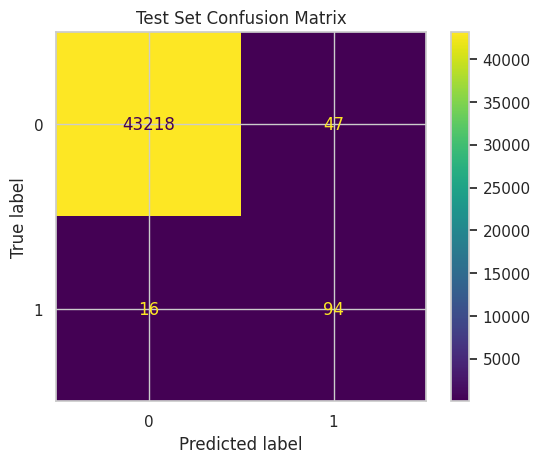

In [ ]:
dt_test_scores_s3 = evaluate_on_test(dt_model_s3, test_s3)

**Catboost testing on Scenario 3**



=== FINAL TEST EVALUATION ===
Precision: 0.9279
Recall: 0.9364
F1 Score: 0.9321
Average Precision: 0.9757
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.93      0.94      0.93       110

    accuracy                           1.00     43375
   macro avg       0.96      0.97      0.97     43375
weighted avg       1.00      1.00      1.00     43375



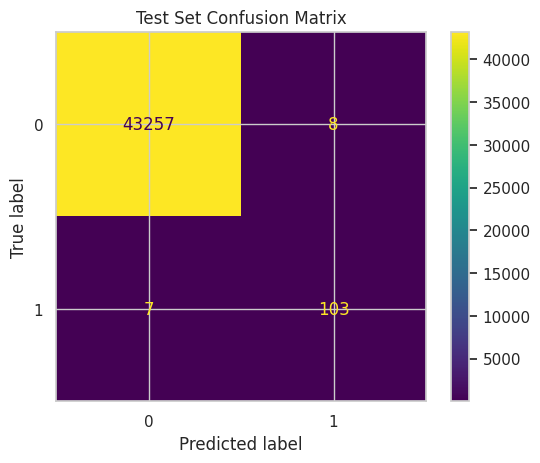

In [ ]:
cat_test_scores_s3 = evaluate_on_test(cat_model_s3, test_s3)

# **Scenario 4: SMOTE & Undersampled W/O User parm**

In [ ]:
session_path = 'session.csv'
df_s4 = pd.read_csv(session_path)

df_s4 = df_s4.drop(columns=['Unnamed: 0','starttime','endtime','sessionid','week','user'])
folds_s4, test_s4 = create_folds(df_s4, smote=True, undersampling=True, smote_ratio=0.03, undersampling_ratio=0.04)
X_train_s4, y_train_s4, X_val_s4, y_val_s4 = folds_s4[0]
X_test_s4, y_test_s4 = test_s4

<ipython-input-3-9c3d3292ea1f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[~target.isin([0,1])] = 1


# **Training on Scenario 4**

**Random Forest  training on Scenario 4**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.8760
Recall: 0.5678
F1 Score: 0.6890
Average Precision: 0.7982
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.88      0.57      0.69       199

    accuracy                           1.00     78074
   macro avg       0.94      0.78      0.84     78074
weighted avg       1.00      1.00      1.00     78074



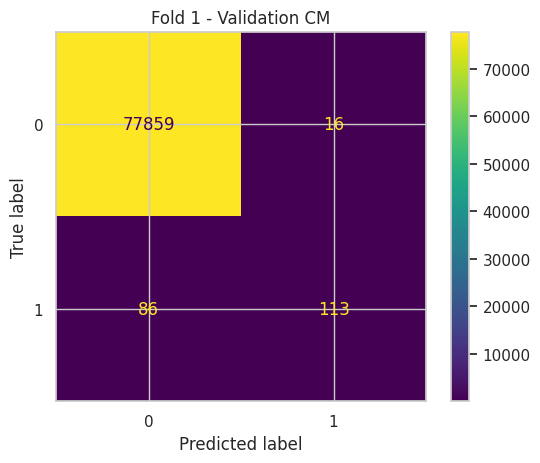



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9048
Recall: 0.5729
F1 Score: 0.7015
Average Precision: 0.7766
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.90      0.57      0.70       199

    accuracy                           1.00     78074
   macro avg       0.95      0.79      0.85     78074
weighted avg       1.00      1.00      1.00     78074



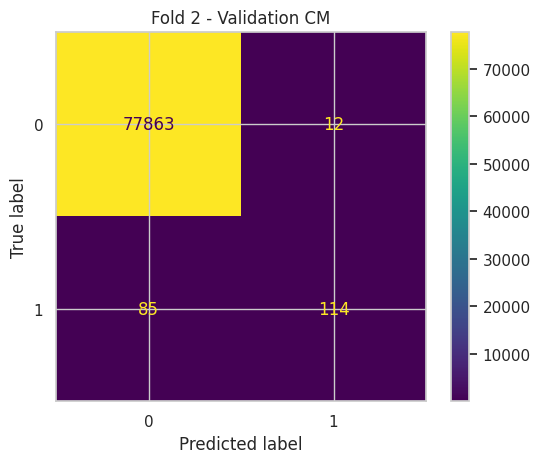



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.8594
Recall: 0.5556
F1 Score: 0.6748
Average Precision: 0.7611
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.86      0.56      0.67       198

    accuracy                           1.00     78073
   macro avg       0.93      0.78      0.84     78073
weighted avg       1.00      1.00      1.00     78073



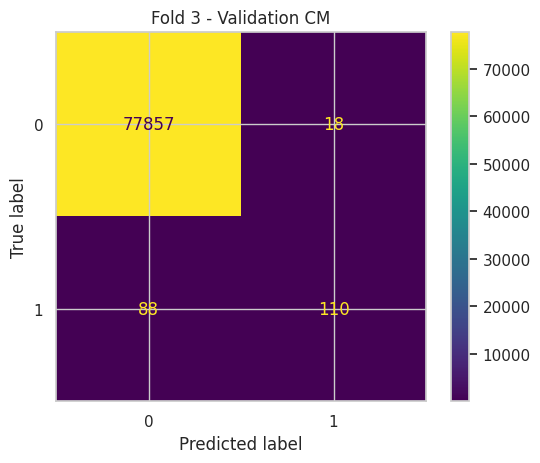



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9297
Recall: 0.6010
F1 Score: 0.7301
Average Precision: 0.8167
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.93      0.60      0.73       198

    accuracy                           1.00     78073
   macro avg       0.96      0.80      0.86     78073
weighted avg       1.00      1.00      1.00     78073



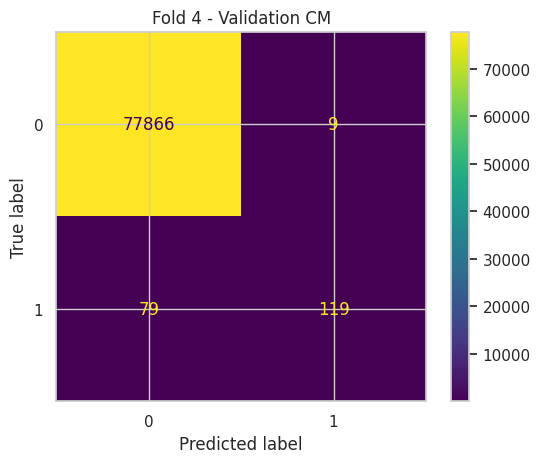



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.8832
Recall: 0.6080
F1 Score: 0.7202
Average Precision: 0.7867
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.88      0.61      0.72       199

    accuracy                           1.00     78073
   macro avg       0.94      0.80      0.86     78073
weighted avg       1.00      1.00      1.00     78073



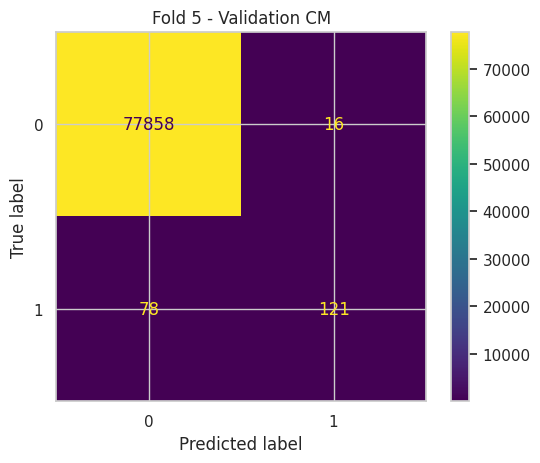


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.8906
avg_recall: 0.5811
avg_f1_score: 0.7031
avg_average_precision: 0.7879

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.8760  0.5678    0.6890         0.7982
Fold 2      0.9048  0.5729    0.7015         0.7766
Fold 3      0.8594  0.5556    0.6748         0.7611
Fold 4      0.9297  0.6010    0.7301         0.8167
Fold 5      0.8832  0.6080    0.7202         0.7867
Average     0.8906  0.5811    0.7031         0.7879


In [ ]:
avg_rf_scores_s4, rf_model_s4, rf_scores_s4 = evaluate_folds(folds_s4, model=rf_model)
clean_df = format_scores(rf_scores_s4)
print("\n===== Evaluation Summary =====")
print(clean_df)

**XGB Classifier training on Scenario 4**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9617
Recall: 0.8844
F1 Score: 0.9215
Average Precision: 0.9723
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.96      0.88      0.92       199

    accuracy                           1.00     78074
   macro avg       0.98      0.94      0.96     78074
weighted avg       1.00      1.00      1.00     78074



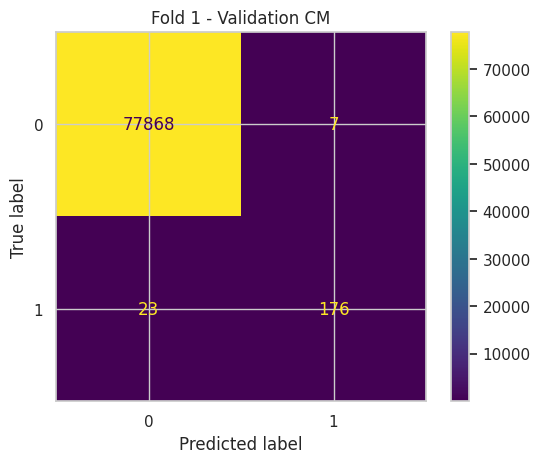



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9223
Recall: 0.8945
F1 Score: 0.9082
Average Precision: 0.9563
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.92      0.89      0.91       199

    accuracy                           1.00     78074
   macro avg       0.96      0.95      0.95     78074
weighted avg       1.00      1.00      1.00     78074



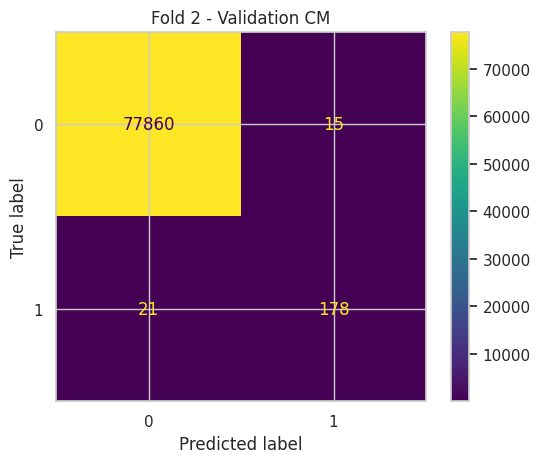



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9465
Recall: 0.8939
F1 Score: 0.9195
Average Precision: 0.9542
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.95      0.89      0.92       198

    accuracy                           1.00     78073
   macro avg       0.97      0.95      0.96     78073
weighted avg       1.00      1.00      1.00     78073



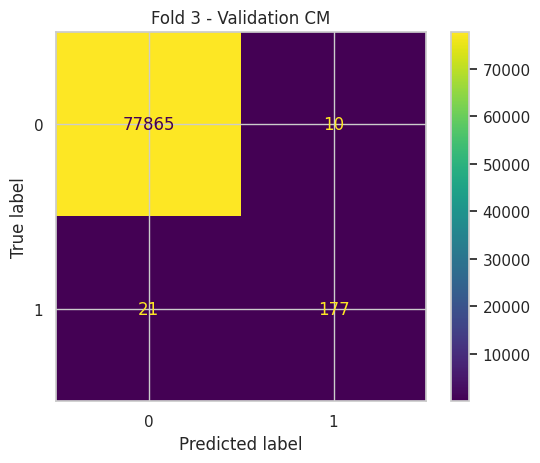



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9189
Recall: 0.8586
F1 Score: 0.8877
Average Precision: 0.9579
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.92      0.86      0.89       198

    accuracy                           1.00     78073
   macro avg       0.96      0.93      0.94     78073
weighted avg       1.00      1.00      1.00     78073



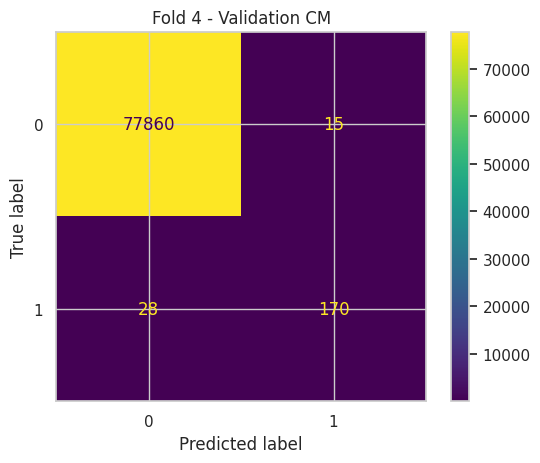



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9358
Recall: 0.8794
F1 Score: 0.9067
Average Precision: 0.9550
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.94      0.88      0.91       199

    accuracy                           1.00     78073
   macro avg       0.97      0.94      0.95     78073
weighted avg       1.00      1.00      1.00     78073



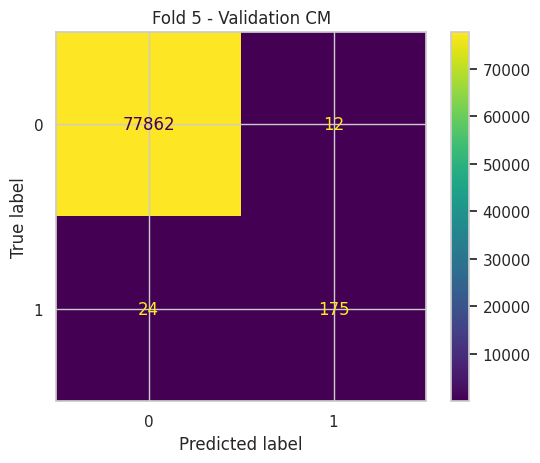


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9371
avg_recall: 0.8822
avg_f1_score: 0.9087
avg_average_precision: 0.9591

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9617  0.8844    0.9215         0.9723
Fold 2      0.9223  0.8945    0.9082         0.9563
Fold 3      0.9465  0.8939    0.9195         0.9542
Fold 4      0.9189  0.8586    0.8877         0.9579
Fold 5      0.9358  0.8794    0.9067         0.9550
Average     0.9370  0.8822    0.9087         0.9591


In [ ]:
avg_xgb_scores_s4, xgb_model_s4, xgb_scores_s4 = evaluate_folds(folds_s4, model=xgb_model)
clean_df = format_scores(xgb_scores_s4)
print("\n===== Evaluation Summary =====")
print(clean_df)

**Decision Tree Classifier training on Scenario 4**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.5429
Recall: 0.7638
F1 Score: 0.6347
Average Precision: 0.4152
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.54      0.76      0.63       199

    accuracy                           1.00     78074
   macro avg       0.77      0.88      0.82     78074
weighted avg       1.00      1.00      1.00     78074



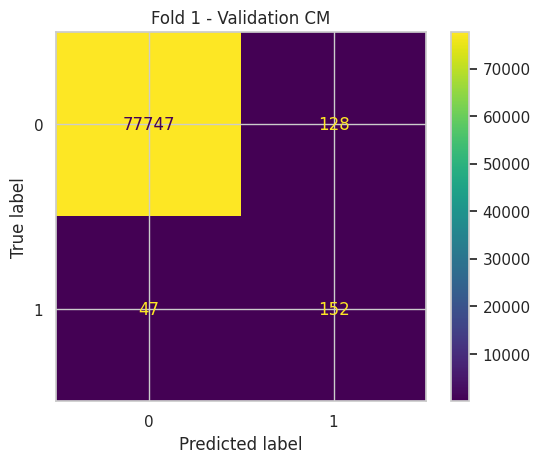



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.5539
Recall: 0.7487
F1 Score: 0.6368
Average Precision: 0.4154
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.55      0.75      0.64       199

    accuracy                           1.00     78074
   macro avg       0.78      0.87      0.82     78074
weighted avg       1.00      1.00      1.00     78074



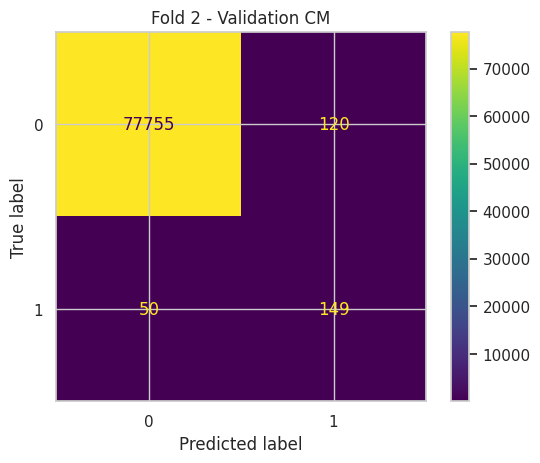



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.6100
Recall: 0.7980
F1 Score: 0.6915
Average Precision: 0.4873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.61      0.80      0.69       198

    accuracy                           1.00     78073
   macro avg       0.80      0.90      0.85     78073
weighted avg       1.00      1.00      1.00     78073



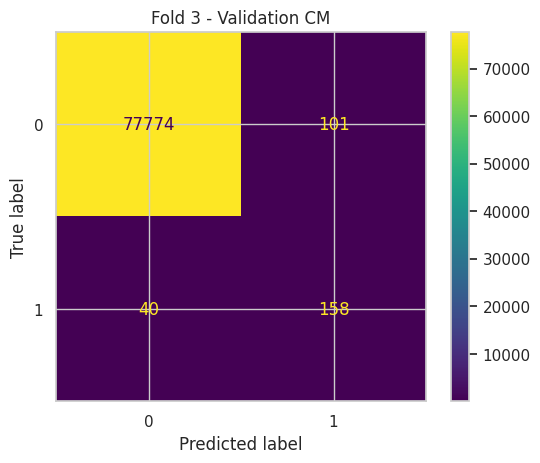



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.5794
Recall: 0.7374
F1 Score: 0.6489
Average Precision: 0.4279
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.58      0.74      0.65       198

    accuracy                           1.00     78073
   macro avg       0.79      0.87      0.82     78073
weighted avg       1.00      1.00      1.00     78073



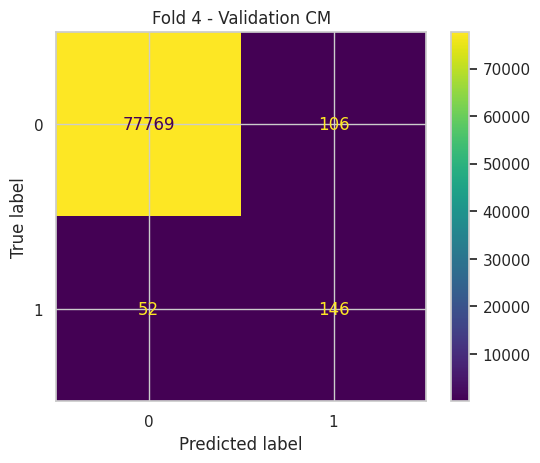



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.4950
Recall: 0.7538
F1 Score: 0.5976
Average Precision: 0.3738
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.50      0.75      0.60       199

    accuracy                           1.00     78073
   macro avg       0.75      0.88      0.80     78073
weighted avg       1.00      1.00      1.00     78073



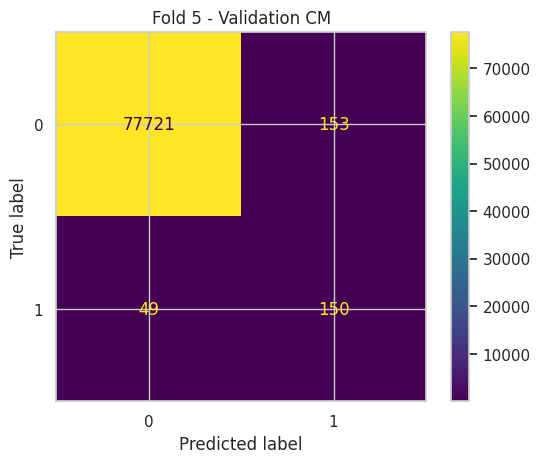


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.5562
avg_recall: 0.7603
avg_f1_score: 0.6419
avg_average_precision: 0.4239

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.5429  0.7638    0.6347         0.4152
Fold 2      0.5539  0.7487    0.6368         0.4154
Fold 3      0.6100  0.7980    0.6915         0.4873
Fold 4      0.5794  0.7374    0.6489         0.4279
Fold 5      0.4950  0.7538    0.5976         0.3738
Average     0.5562  0.7603    0.6419         0.4239


In [ ]:
avg_dt_scores_s4, dt_model_s4, dt_scores_s4 = evaluate_folds(folds_s4, model=dt_model)
clean_df = format_scores(dt_scores_s4)
print("\n===== Evaluation Summary =====")
print(clean_df)

**CatBoost Model training on Scenario 4**

=== Cross-Validation Fold Results ===


Fold 1
.....VALIDATION EVALUATION.....
Precision: 0.9831
Recall: 0.8794
F1 Score: 0.9284
Average Precision: 0.9690
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.98      0.88      0.93       199

    accuracy                           1.00     78074
   macro avg       0.99      0.94      0.96     78074
weighted avg       1.00      1.00      1.00     78074



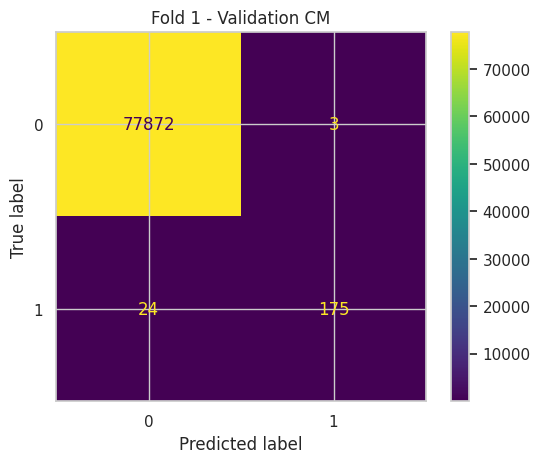



Fold 2
.....VALIDATION EVALUATION.....
Precision: 0.9312
Recall: 0.8844
F1 Score: 0.9072
Average Precision: 0.9452
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.93      0.88      0.91       199

    accuracy                           1.00     78074
   macro avg       0.97      0.94      0.95     78074
weighted avg       1.00      1.00      1.00     78074



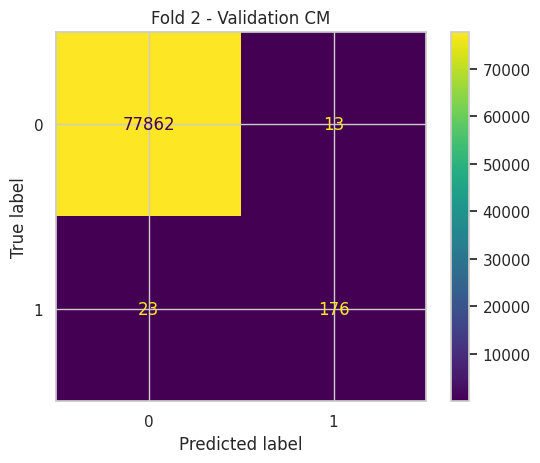



Fold 3
.....VALIDATION EVALUATION.....
Precision: 0.9516
Recall: 0.8939
F1 Score: 0.9219
Average Precision: 0.9552
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.95      0.89      0.92       198

    accuracy                           1.00     78073
   macro avg       0.98      0.95      0.96     78073
weighted avg       1.00      1.00      1.00     78073



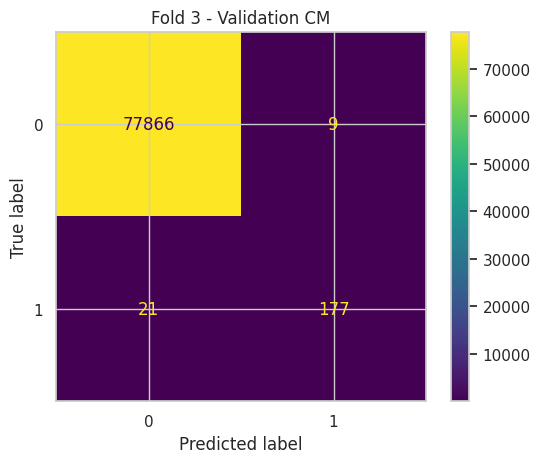



Fold 4
.....VALIDATION EVALUATION.....
Precision: 0.9312
Recall: 0.8889
F1 Score: 0.9096
Average Precision: 0.9680
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77875
           1       0.93      0.89      0.91       198

    accuracy                           1.00     78073
   macro avg       0.97      0.94      0.95     78073
weighted avg       1.00      1.00      1.00     78073



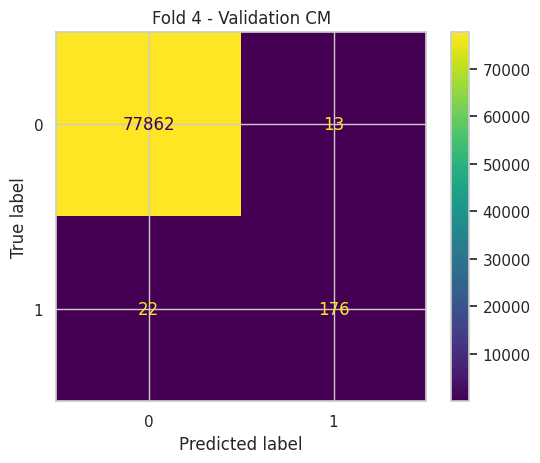



Fold 5
.....VALIDATION EVALUATION.....
Precision: 0.9457
Recall: 0.8744
F1 Score: 0.9086
Average Precision: 0.9459
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77874
           1       0.95      0.87      0.91       199

    accuracy                           1.00     78073
   macro avg       0.97      0.94      0.95     78073
weighted avg       1.00      1.00      1.00     78073



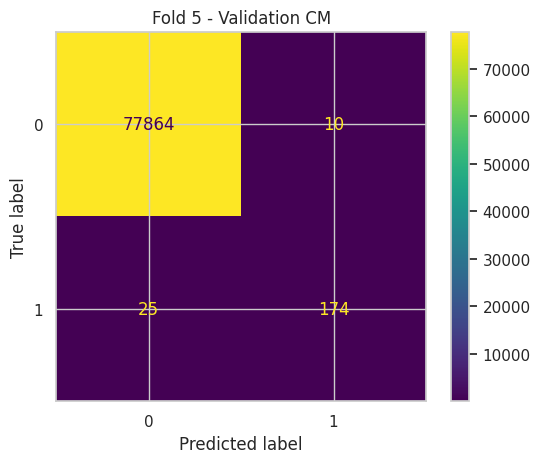


=== AVERAGE CROSS-VALIDATION SCORES ===
avg_precision: 0.9486
avg_recall: 0.8842
avg_f1_score: 0.9151
avg_average_precision: 0.9567

Training final model on all data...

===== Evaluation Summary =====
         Precision  Recall  F1 Score  Avg Precision
Fold                                               
Fold 1      0.9831  0.8794    0.9284         0.9690
Fold 2      0.9312  0.8844    0.9072         0.9452
Fold 3      0.9516  0.8939    0.9219         0.9552
Fold 4      0.9312  0.8889    0.9096         0.9680
Fold 5      0.9457  0.8744    0.9086         0.9459
Average     0.9486  0.8842    0.9151         0.9567


In [ ]:
avg_cat_scores_s4, cat_model_s4, cat_scores_s4  = evaluate_folds(folds_s4, model=cat_model)
clean_df = format_scores(cat_scores_s4)
print("\n===== Evaluation Summary =====")
print(clean_df)

# **Testing on Scenario 4**

**Random Forest Model Testing on Scenario 4**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.9710
Recall: 0.6091
F1 Score: 0.7486
Average Precision: 0.8654
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.97      0.61      0.75       110

    accuracy                           1.00     43375
   macro avg       0.99      0.80      0.87     43375
weighted avg       1.00      1.00      1.00     43375



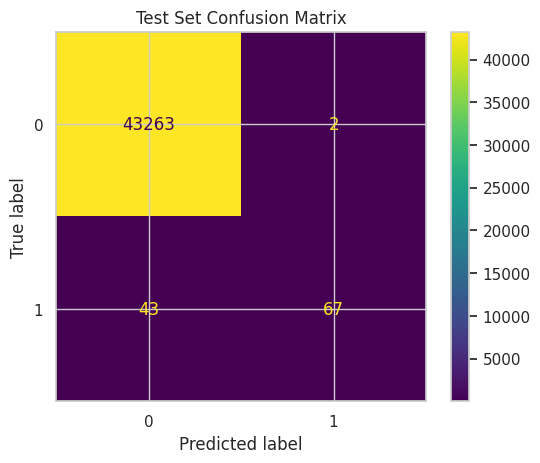

In [ ]:
rf_test_scores_s4 = evaluate_on_test(rf_model_s4, test_s4)

**XGB Model Testing on Scenario 4**



=== FINAL TEST EVALUATION ===
Precision: 0.9697
Recall: 0.8727
F1 Score: 0.9187
Average Precision: 0.9667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.97      0.87      0.92       110

    accuracy                           1.00     43375
   macro avg       0.98      0.94      0.96     43375
weighted avg       1.00      1.00      1.00     43375



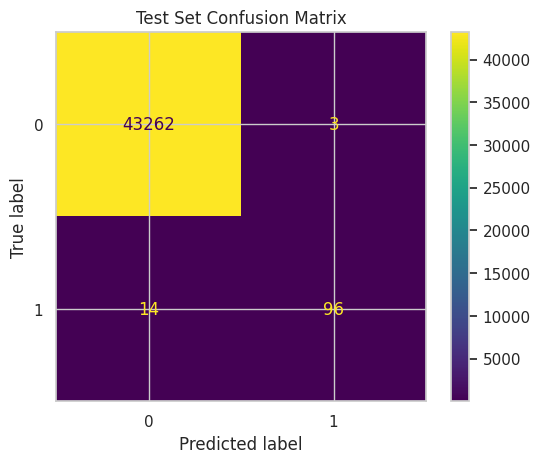

In [ ]:
xgb_test_scores_s4 = evaluate_on_test(xgb_model_s4, test_s4)

**DT Model Testing on Scenario 4**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(




=== FINAL TEST EVALUATION ===
Precision: 0.5030
Recall: 0.7545
F1 Score: 0.6036
Average Precision: 0.3802
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.50      0.75      0.60       110

    accuracy                           1.00     43375
   macro avg       0.75      0.88      0.80     43375
weighted avg       1.00      1.00      1.00     43375



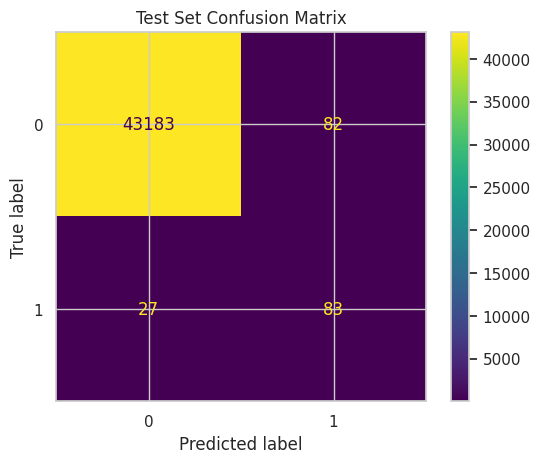

In [ ]:
dt_test_scores_s4 = evaluate_on_test(dt_model_s4, test_s4)

**CAT Testing on Scenario 4**



=== FINAL TEST EVALUATION ===
Precision: 0.9703
Recall: 0.8909
F1 Score: 0.9289
Average Precision: 0.9663
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.97      0.89      0.93       110

    accuracy                           1.00     43375
   macro avg       0.99      0.95      0.96     43375
weighted avg       1.00      1.00      1.00     43375



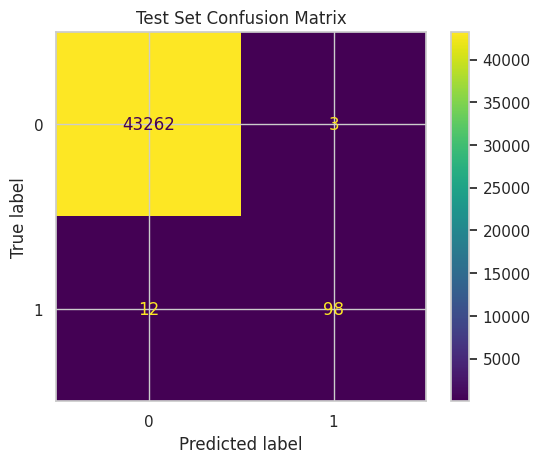

In [ ]:
cat_test_scores_s4 = evaluate_on_test(cat_model_s4, test_s4)

# **Meta Learner implementation and Results**

**Scenario 1:Baseline**


=== Generating Out-of-Fold (OOF) Meta-Features ===

Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...

=== Meta-Learner Evaluation on OOF Training Data ===
Precision: 0.9725
Recall: 0.9245
F1 Score: 0.9479
Average Precision: 0.9805
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    389374
           1       0.97      0.92      0.95       993

    accuracy                           1.00    390367
   macro avg       0.99      0.96      0.97    390367
weighted avg       1.00      1.00      1.00    390367



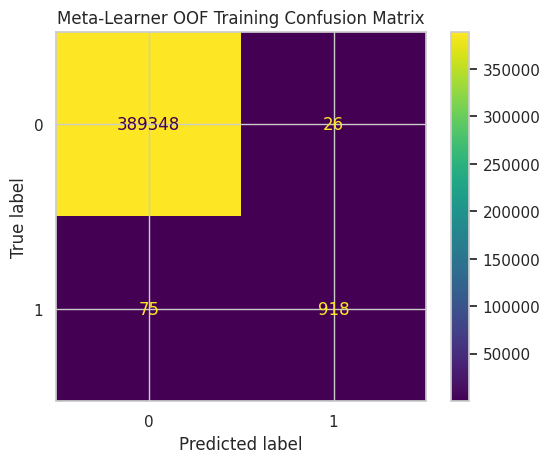


=== Meta-Learner Evaluation on Test Set ===
Precision: 0.9808
Recall: 0.9273
F1 Score: 0.9533
Average Precision: 0.9854
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.98      0.93      0.95       110

    accuracy                           1.00     43375
   macro avg       0.99      0.96      0.98     43375
weighted avg       1.00      1.00      1.00     43375



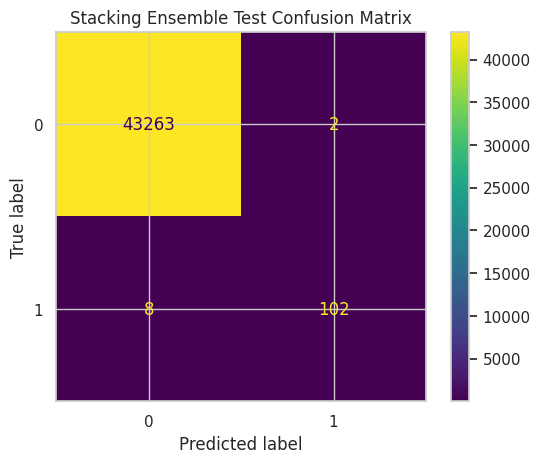

In [ ]:
meta_results_s1 = train_stacking_ensemble_with_meta_learner(folds_s1, test_s1)

**Scenario 2: META LEARNER WITH Statistical Feature Selection**


=== Generating Out-of-Fold (OOF) Meta-Features ===

Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...

=== Meta-Learner Evaluation on OOF Training Data ===
Precision: 0.9846
Recall: 0.9648
F1 Score: 0.9746
Average Precision: 0.9878
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    389375
           1       0.98      0.96      0.97       995

    accuracy                           1.00    390370
   macro avg       0.99      0.98      0.99    390370
weighted avg       1.00      1.00      1.00    390370



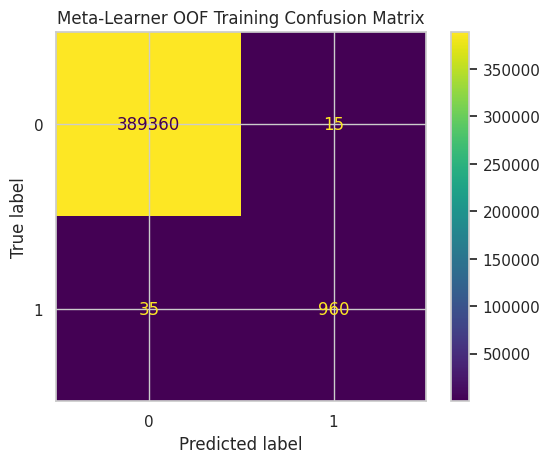


=== Meta-Learner Evaluation on Test Set ===
Precision: 0.9904
Recall: 0.9364
F1 Score: 0.9626
Average Precision: 0.9888
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.99      0.94      0.96       110

    accuracy                           1.00     43375
   macro avg       1.00      0.97      0.98     43375
weighted avg       1.00      1.00      1.00     43375



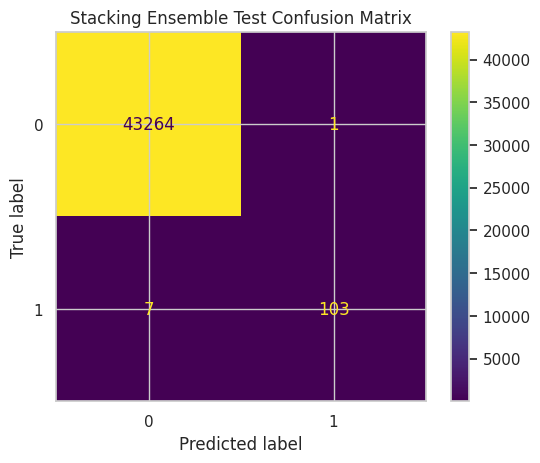

In [ ]:
meta_results_s2 = train_stacking_ensemble_with_meta_learner(folds_2_top50, test_data_s2)

**Scenario 3: Meta Learner with SMOTE & Undersampling**


=== Generating Out-of-Fold (OOF) Meta-Features ===

Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...

=== Meta-Learner Evaluation on OOF Training Data ===
Precision: 0.9508
Recall: 0.9154
F1 Score: 0.9328
Average Precision: 0.9732
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    389374
           1       0.95      0.92      0.93       993

    accuracy                           1.00    390367
   macro avg       0.98      0.96      0.97    390367
weighted avg       1.00      1.00      1.00    390367



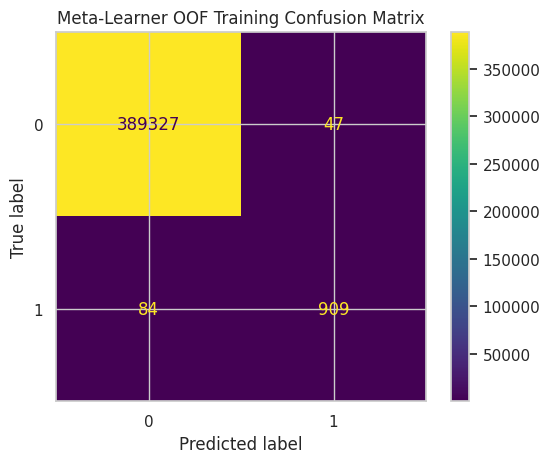


=== Meta-Learner Evaluation on Test Set ===
Precision: 0.9804
Recall: 0.9091
F1 Score: 0.9434
Average Precision: 0.9747
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.98      0.91      0.94       110

    accuracy                           1.00     43375
   macro avg       0.99      0.95      0.97     43375
weighted avg       1.00      1.00      1.00     43375



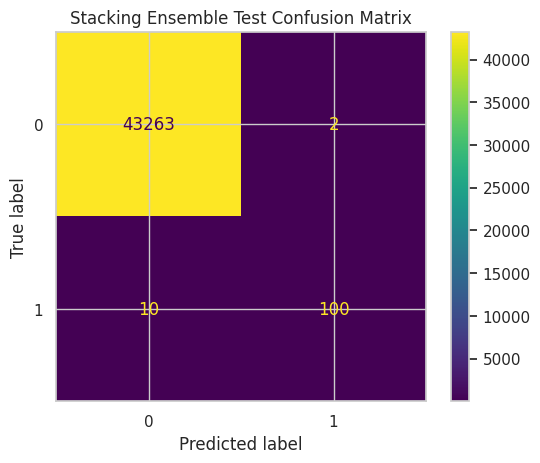

In [ ]:
meta_results_s3 = train_stacking_ensemble_with_meta_learner(folds_s3, test_s3)

**Scenario 4: Meta Learner with SMOTE & Undersampling without User**


=== Generating Out-of-Fold (OOF) Meta-Features ===

Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...

=== Meta-Learner Evaluation on OOF Training Data ===
Precision: 0.9528
Recall: 0.8953
F1 Score: 0.9232
Average Precision: 0.9654
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    389374
           1       0.95      0.90      0.92       993

    accuracy                           1.00    390367
   macro avg       0.98      0.95      0.96    390367
weighted avg       1.00      1.00      1.00    390367



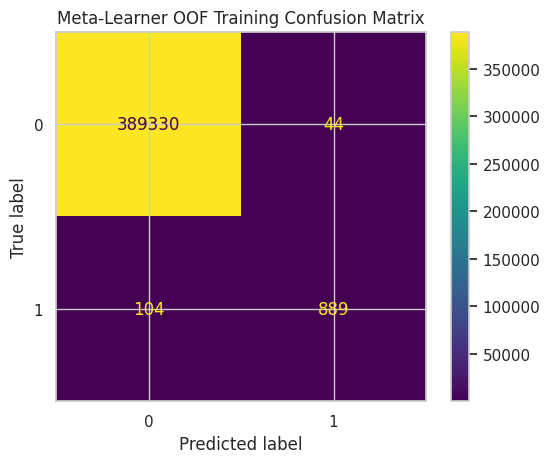


=== Meta-Learner Evaluation on Test Set ===
Precision: 0.9712
Recall: 0.9182
F1 Score: 0.9439
Average Precision: 0.9589
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.97      0.92      0.94       110

    accuracy                           1.00     43375
   macro avg       0.99      0.96      0.97     43375
weighted avg       1.00      1.00      1.00     43375



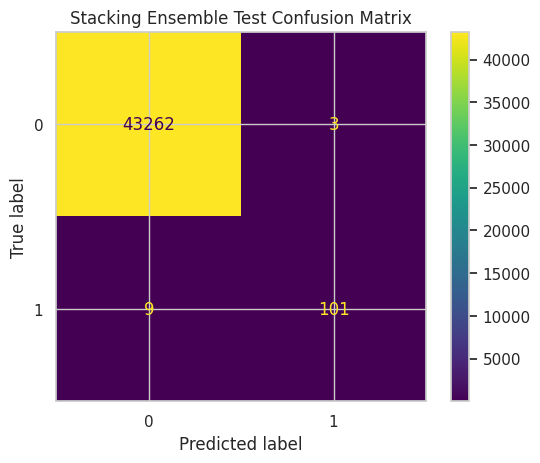

In [ ]:
meta_results_s4 = train_stacking_ensemble_with_meta_learner(folds_s4, test_s4)

**New Scenario, Scenario 5 based on previous results**

**Scenario 5: Meta Learner with SMOTE & Undersampling without User on top 50**

In [ ]:
session_path = 'session.csv'
df_fs_2 = pd.read_csv(session_path)
df_fs_2 = df_fs_2.drop(columns=['Unnamed: 0','starttime','endtime','sessionid','week'])
folds_fs_2, test_fs_2 = create_folds(df_fs_2, smote=False, undersampling=False, smote_ratio=0.03, undersampling_ratio=0.04)
X_train_fs_2, y_train_fs_2, X_val_fs_2, y_val_fs_2 = folds_fs_2[0]
X_test_fs_2, y_test_fs_2 = test_fs_2

<ipython-input-3-9c3d3292ea1f>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target.loc[~target.isin([0,1])] = 1


In [ ]:
folds_fs_2_top50 = [
    [X_train_fs_2[top_features].drop(columns=['user'], errors='ignore'), y_train_fs_2,
     X_val_fs_2[top_features].drop(columns=['user'], errors='ignore'), y_val_fs_2]
    for X_train, y_train, X_val, y_val in folds_fs_2
]

# Apply top_features and drop the 'user' column for the test set
X_test_fs_2_top50 = X_test_fs_2[top_features].drop(columns=['user'], errors='ignore')
test_fs_2_top50 = [X_test_fs_2_top50, y_test_fs_2]


=== Generating Out-of-Fold (OOF) Meta-Features ===

Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...

=== Meta-Learner Evaluation on OOF Training Data ===
Precision: 0.9795
Recall: 0.9598
F1 Score: 0.9695
Average Precision: 0.9901
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    389375
           1       0.98      0.96      0.97       995

    accuracy                           1.00    390370
   macro avg       0.99      0.98      0.98    390370
weighted avg       1.00      1.00      1.00    390370



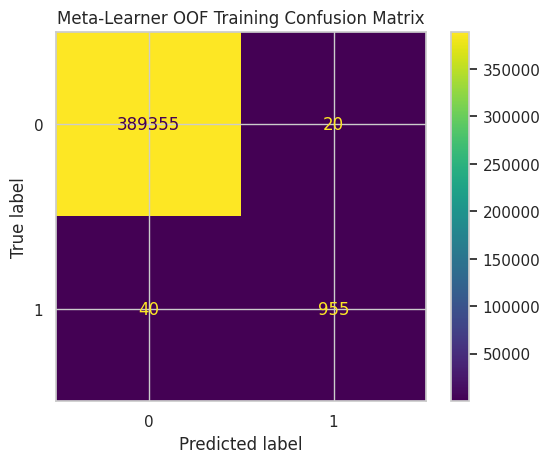


=== Meta-Learner Evaluation on Test Set ===
Precision: 0.9623
Recall: 0.9273
F1 Score: 0.9444
Average Precision: 0.9883
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.96      0.93      0.94       110

    accuracy                           1.00     43375
   macro avg       0.98      0.96      0.97     43375
weighted avg       1.00      1.00      1.00     43375



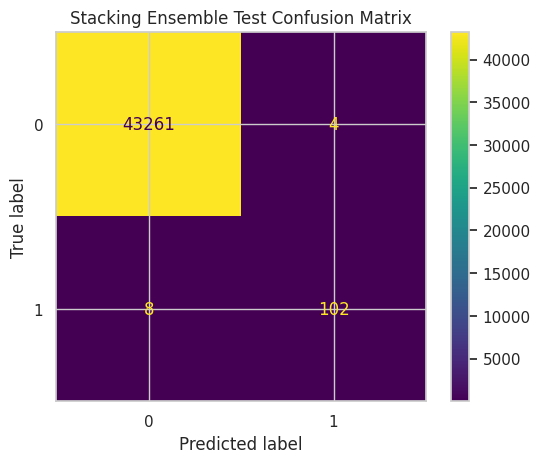

In [ ]:
meta_results_s5 = train_stacking_ensemble_with_meta_learner(folds_fs_2_top50, test_fs_2_top50)

# **PLOTS OF RESULTS**

**Graphs for Scenario 1**

In [ ]:
model_scores_s1 = {
    'XGBoost': xgb_test_scores_s1,
    'Random Forest': rf_test_scores_s1,
    'Decision Tree': dt_test_scores_s1,
    'CatBoost': cat_test_scores_s1,
    'Meta Learner': meta_results_s1
}

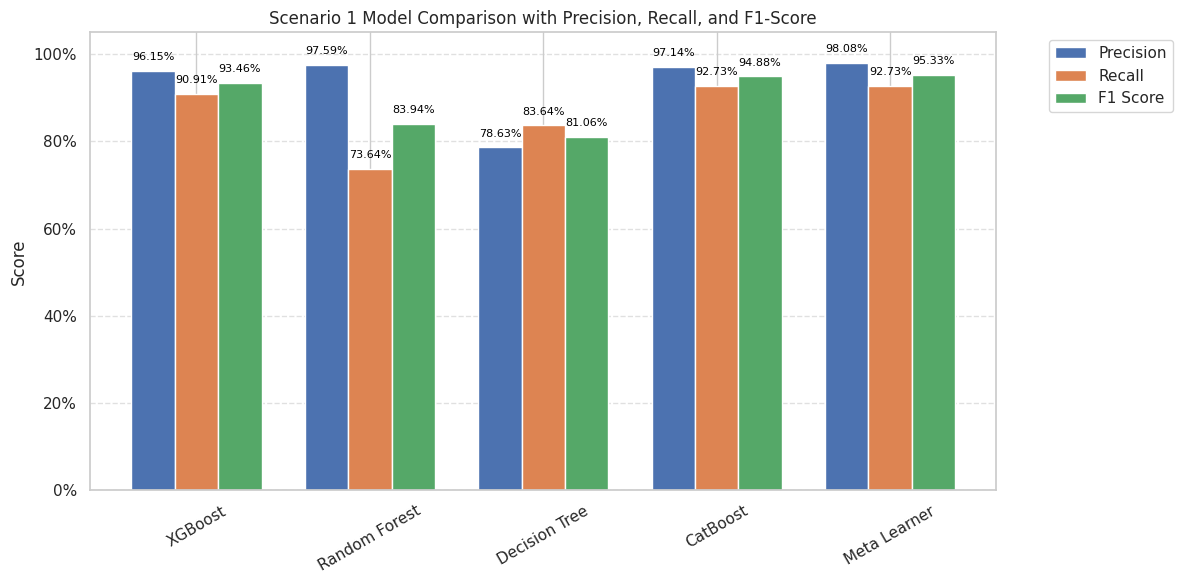

In [ ]:
metrics_to_plot = ['precision', 'recall', 'f1_score']
plot_model_comparison(model_scores_s1, metrics_to_plot=metrics_to_plot, title="Scenario 1 Model Comparison with Precision, Recall, and F1-Score")

**Graphs for Scenario 2**

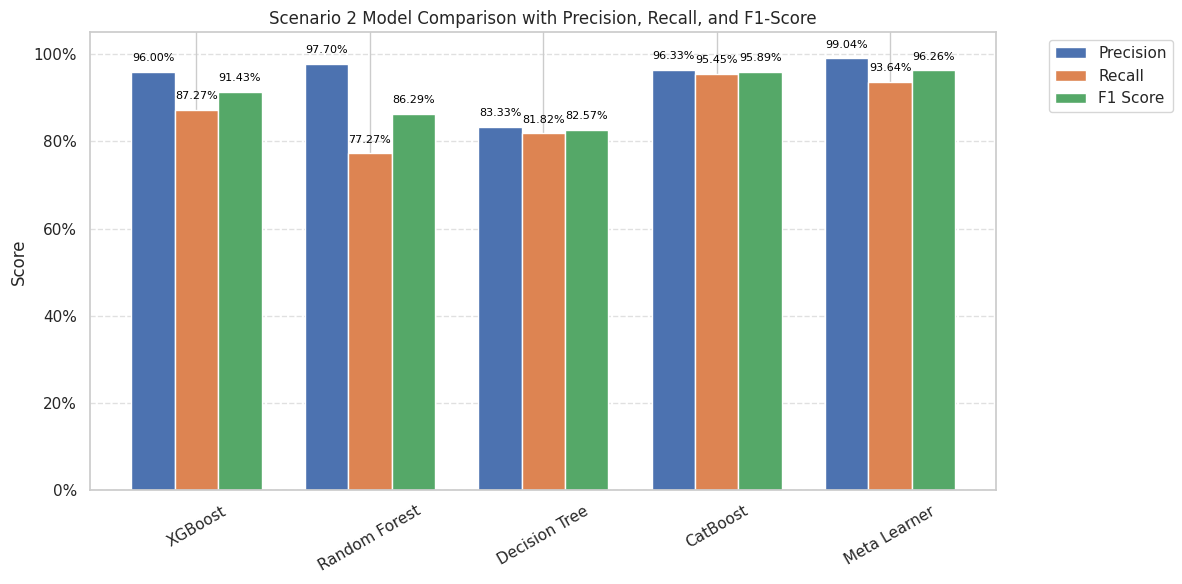

In [ ]:
model_scores_2 = {
    'XGBoost': xgb_test_scores_s2,
    'Random Forest': rf_test_scores_s2,
    'Decision Tree': dt_test_scores_s2,
    'CatBoost': cat_test_scores_s2,
    'Meta Learner': meta_results_s2
}

plot_model_comparison(model_scores_2, metrics_to_plot=metrics_to_plot, title="Scenario 2 Model Comparison with Precision, Recall, and F1-Score")

**Graphs for Scenario 3**

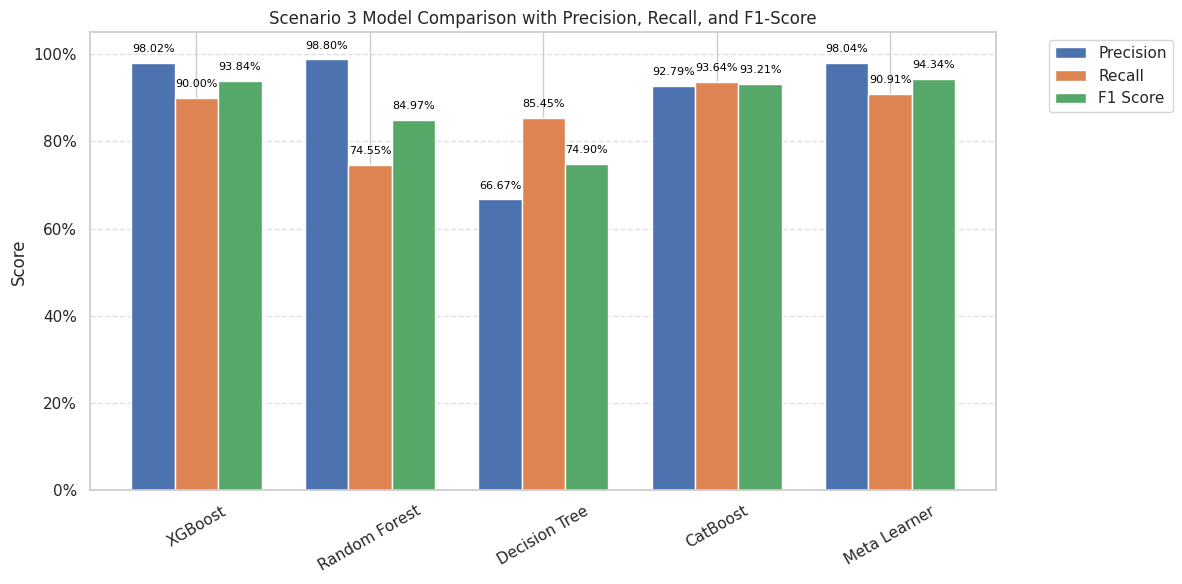

In [ ]:
model_scores_s3 = {
    'XGBoost': xgb_test_scores_s3,
    'Random Forest': rf_test_scores_s3,
    'Decision Tree': dt_test_scores_s3,
    'CatBoost': cat_test_scores_s3,
    'Meta Learner': meta_results_s3
}

plot_model_comparison(model_scores_s3, metrics_to_plot=metrics_to_plot, title="Scenario 3 Model Comparison with Precision, Recall, and F1-Score")

**Graphs for Scenario 4**

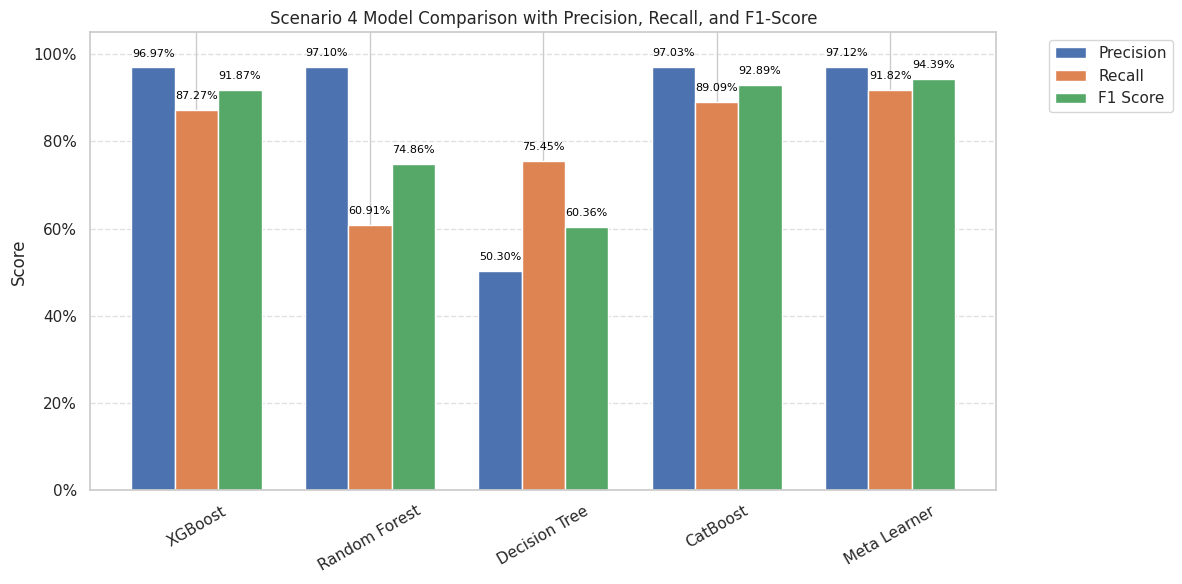

In [ ]:
model_scores_s4 = {
    'XGBoost': xgb_test_scores_s4,
    'Random Forest': rf_test_scores_s4,
    'Decision Tree': dt_test_scores_s4,
    'CatBoost': cat_test_scores_s4,
    'Meta Learner': meta_results_s4
}

plot_model_comparison(model_scores_s4, metrics_to_plot=metrics_to_plot, title="Scenario 4 Model Comparison with Precision, Recall, and F1-Score")

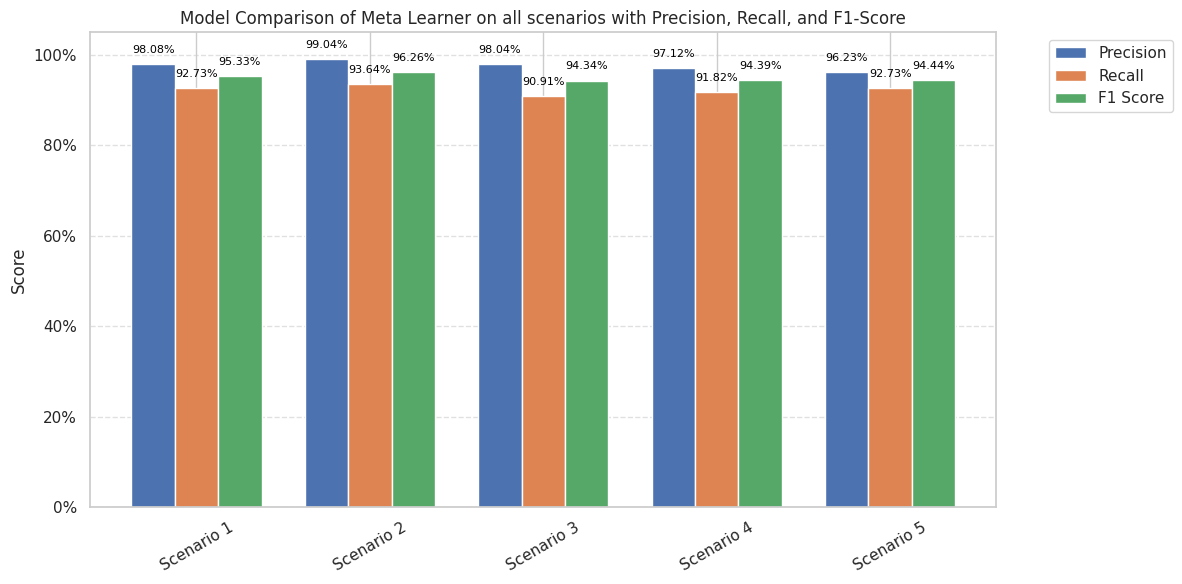

In [ ]:
metrics_to_plot = ['precision', 'recall', 'f1_score']

meta_learner_all_scores= {
    'Scenario 1': meta_results_s1,
    'Scenario 2': meta_results_s2,
    'Scenario 3': meta_results_s3,
    'Scenario 4': meta_results_s4,
    'Scenario 5': meta_results_s5,
}

plot_model_comparison(meta_learner_all_scores, metrics_to_plot=metrics_to_plot, title="Model Comparison of Meta Learner on all scenarios with Precision, Recall, and F1-Score")

**Graphs for Meta Learner Performance on multiple Scenarios**

# **Hyper Parameter Tuned Meta learner With Scenario 5**

NOTE: Hyper parameter tuning was done on seperate script

In [ ]:
from sklearn.preprocessing import StandardScaler

def train_stacking_ensemble_with_meta_learner_tuned(folds, test):
    oof_meta_features = []
    oof_meta_targets = []

    print("\n=== Generating Out-of-Fold (OOF) Meta-Features ===")

    for i, (X_train, y_train, X_val, y_val) in enumerate(folds):
        print(f"\nProcessing Fold {i+1}...")

        # Best parameters for each model
        catboost_params = {
            'learning_rate': 0.3,
            'l2_leaf_reg': 5,
            'iterations': 1000,
            'depth': 6,
            'border_count': 64,
            'bagging_temperature': 0.0
        }

        rf_params = {
            'n_estimators': 100,
            'min_samples_split': 2,
            'min_samples_leaf': 4,
            'max_features': 'sqrt',
            'max_depth': 20,
            'bootstrap': False
        }

        dt_params = {
            'min_samples_split': 5,
            'min_samples_leaf': 6,
            'max_features': None,
            'max_depth': 15,
            'criterion': 'entropy'
        }

        xgb_params = {
            'subsample': 0.8,
            'reg_lambda': 0.5,
            'reg_alpha': 0.5,
            'n_estimators': 300,
            'min_child_weight': 1,
            'max_depth': 5,
            'learning_rate': 0.1,
            'gamma': 0.3,
            'colsample_bytree': 1.0
        }

        # Initializing the models with the best parameters
        rf = RandomForestClassifier(random_state=42, **rf_params)
        dt = DecisionTreeClassifier(random_state=42, **dt_params)
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **xgb_params)
        cat = CatBoostClassifier(verbose=0, random_state=42, **catboost_params)

        rf.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        xgb.fit(X_train, y_train)
        cat.fit(X_train, y_train)

        rf_val = rf.predict_proba(X_val)[:, 1]
        dt_val = dt.predict_proba(X_val)[:, 1]
        xgb_val = xgb.predict_proba(X_val)[:, 1]
        cat_val = cat.predict_proba(X_val)[:, 1]

        meta_features_fold = pd.DataFrame({
            'rf': rf_val,
            'dt': dt_val,
            'xgb': xgb_val,
            'cat': cat_val
        })
        oof_meta_features.append(meta_features_fold)
        oof_meta_targets.append(y_val.reset_index(drop=True))

    meta_X_train = pd.concat(oof_meta_features, ignore_index=True)
    meta_y_train = pd.concat(oof_meta_targets, ignore_index=True)

    # Scale meta-features
    scaler_meta = StandardScaler()
    meta_X_train_scaled = scaler_meta.fit_transform(meta_X_train)

    meta_learner = LogisticRegression(max_iter=1000)
    meta_learner.fit(meta_X_train_scaled, meta_y_train)

    # === Evaluation on OOF meta-training data ===
    meta_train_preds = meta_learner.predict(meta_X_train_scaled)
    meta_train_proba = meta_learner.predict_proba(meta_X_train_scaled)[:, 1]

    precision_oof = precision_score(meta_y_train, meta_train_preds, zero_division=0)
    recall_oof = recall_score(meta_y_train, meta_train_preds, zero_division=0)
    f1_oof = f1_score(meta_y_train, meta_train_preds, zero_division=0)
    avg_precision_oof = average_precision_score(meta_y_train, meta_train_proba)
    report_oof = classification_report(meta_y_train, meta_train_preds, zero_division=0)
    cm_oof = confusion_matrix(meta_y_train, meta_train_preds)

    print("\n=== Meta-Learner Evaluation on OOF Training Data ===")
    print(f"Precision: {precision_oof:.4f}")
    print(f"Recall: {recall_oof:.4f}")
    print(f"F1 Score: {f1_oof:.4f}")
    print(f"Average Precision: {avg_precision_oof:.4f}")
    print("Classification Report:\n", report_oof)

    disp_oof = ConfusionMatrixDisplay(confusion_matrix=cm_oof)
    disp_oof.plot()
    plt.title("Meta-Learner OOF Training Confusion Matrix")
    plt.show()

    # === Test Evaluation ===
    X_test, y_test = test
    full_X = pd.concat([fold[0] for fold in folds], ignore_index=True)
    full_y = pd.concat([fold[1] for fold in folds], ignore_index=True)

    rf.fit(full_X, full_y)
    dt.fit(full_X, full_y)
    xgb.fit(full_X, full_y)
    cat.fit(full_X, full_y)

    X_test_df = pd.DataFrame(X_test, columns=full_X.columns)

    rf_test = rf.predict_proba(X_test)[:, 1]
    dt_test = dt.predict_proba(X_test)[:, 1]
    xgb_test = xgb.predict_proba(X_test)[:, 1]
    cat_test = cat.predict_proba(X_test)[:, 1]

    meta_X_test = pd.DataFrame({
        'rf': rf_test,
        'dt': dt_test,
        'xgb': xgb_test,
        'cat': cat_test
    })

    meta_X_test_scaled = scaler_meta.transform(meta_X_test)

    meta_preds = meta_learner.predict(meta_X_test_scaled)
    meta_proba = meta_learner.predict_proba(meta_X_test_scaled)[:, 1]

    precision = precision_score(y_test, meta_preds, zero_division=0)
    recall = recall_score(y_test, meta_preds, zero_division=0)
    f1 = f1_score(y_test, meta_preds, zero_division=0)
    avg_precision = average_precision_score(y_test, meta_proba)
    report = classification_report(y_test, meta_preds, zero_division=0)
    cm = confusion_matrix(y_test, meta_preds)

    print("\n=== Meta-Learner Evaluation on Test Set ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("Classification Report:\n", report)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Stacking Ensemble Test Confusion Matrix")
    plt.show()

    return {
        # Test set
        'predictions': meta_preds,
        'probabilities': meta_proba,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average_precision': avg_precision,
        'classification_report': report,
        'confusion_matrix': cm,
        # OOF meta-training set
        'oof_precision': precision_oof,
        'oof_recall': recall_oof,
        'oof_f1_score': f1_oof,
        'oof_average_precision': avg_precision_oof,
        'oof_classification_report': report_oof,
        'oof_confusion_matrix': cm_oof,
        # Trained components
        'scaler_meta': scaler_meta,
        'meta_learner': meta_learner,
        'meta_X_test': meta_X_test,
        'meta_X_test_scaled': meta_X_test_scaled,
        'rf_model': rf,
        'dt_model': dt,
        'xgb_model': xgb,
        'cat_model': cat
    }


=== Generating Out-of-Fold (OOF) Meta-Features ===

Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...

=== Meta-Learner Evaluation on OOF Training Data ===
Precision: 0.9791
Recall: 0.9397
F1 Score: 0.9590
Average Precision: 0.9859
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    389375
           1       0.98      0.94      0.96       995

    accuracy                           1.00    390370
   macro avg       0.99      0.97      0.98    390370
weighted avg       1.00      1.00      1.00    390370



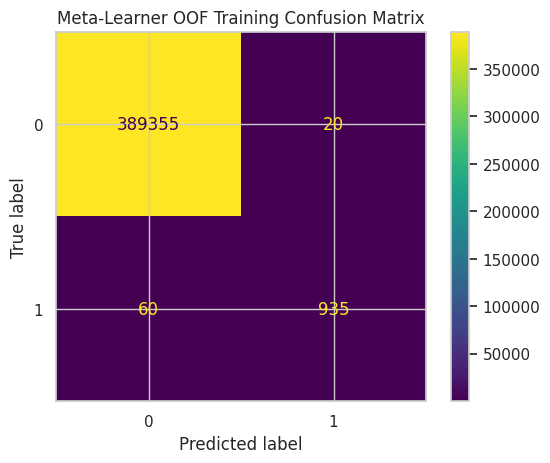


=== Meta-Learner Evaluation on Test Set ===
Precision: 0.9626
Recall: 0.9364
F1 Score: 0.9493
Average Precision: 0.9774
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43265
           1       0.96      0.94      0.95       110

    accuracy                           1.00     43375
   macro avg       0.98      0.97      0.97     43375
weighted avg       1.00      1.00      1.00     43375



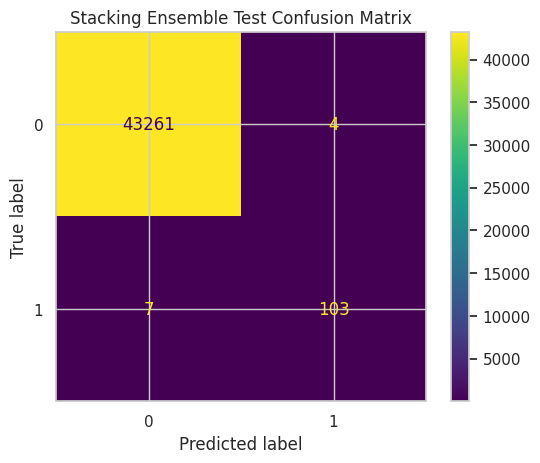

In [ ]:
meta_results_tuned = train_stacking_ensemble_with_meta_learner_tuned(folds_fs_2_top50, test_fs_2_top50)

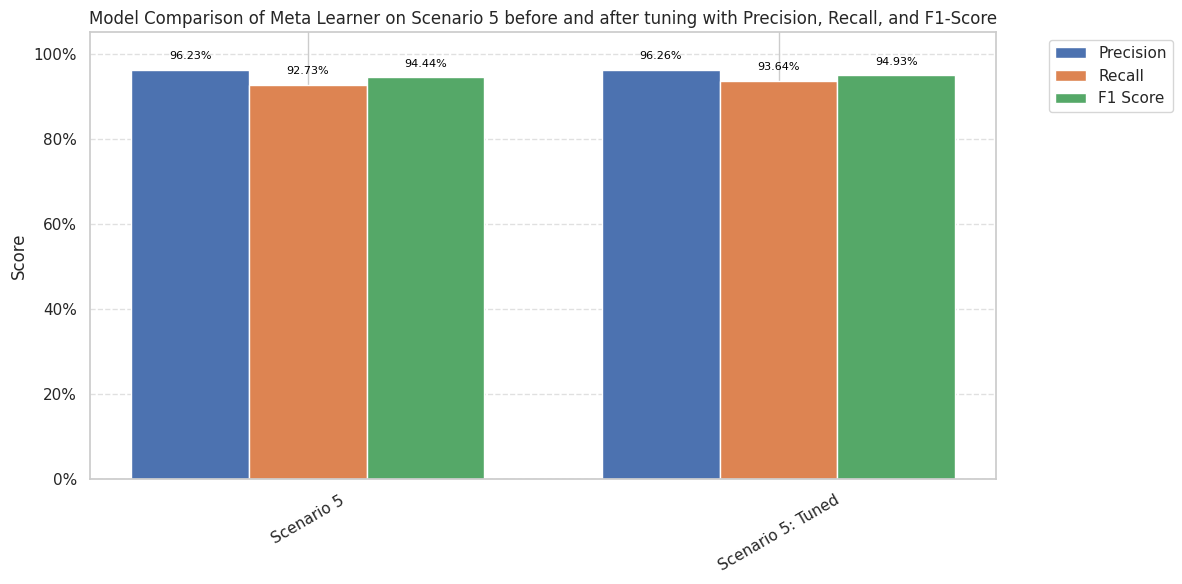

In [ ]:
meta_learner_tuned= {
    'Scenario 5': meta_results_s5,
    'Scenario 5: Tuned': meta_results_tuned,
}

plot_model_comparison(meta_learner_tuned, metrics_to_plot=metrics_to_plot, title="Model Comparison of Meta Learner on Scenario 5 before and after tuning with Precision, Recall, and F1-Score")